In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
def load_data():
    """Load and prepare the datasets"""
    
    try:
        sales = pd.read_csv('assignment4.1a.csv')
        promos = pd.read_csv('PromotionDates.csv')

        # Convert to datetime format
        sales['Date'] = pd.to_datetime(sales['Date'])
        promos['StartDate'] = pd.to_datetime(promos['StartDate'], format='mixed', dayfirst=True)
        promos['EndDate'] = pd.to_datetime(promos['EndDate'], format='mixed', dayfirst=True)

        # Handle negative sales as zero
        sales['Net_Sales'] = np.where(sales['SalesQuantity'] < 0, 0, sales['SalesQuantity'])

        return sales, promos.head(4)  # Use only first 4 promotions
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return pd.DataFrame(), pd.DataFrame()

In [3]:
## load data
sales, promos = load_data()

In [4]:
## take a glimpse at sales data
sales.head()

,Date,StoreCode,ProductCode,SalesQuantity,Net_Sales
0,2015-01-01,8,9,-1,0
1,2015-01-01,131,9,1,1
2,2015-01-01,144,9,2,2
3,2015-01-01,203,9,2,2
4,2015-01-01,256,9,0,0


In [5]:
## take a glimpse at promotion data
promos

,Period,StartDate,EndDate
0,Promo1,2015-10-02,2015-02-17
1,Promo2,2015-03-15,2015-03-22
2,Promo3,2015-05-24,2015-01-06
3,Promo4,2015-06-21,2015-06-28


In [6]:
## check sales dataframe has null
sales.isnull().sum()

Date             0
StoreCode        0
ProductCode      0
SalesQuantity    0
Net_Sales        0
dtype: int64

In [7]:
## get summary statistics of sales data
sales[['SalesQuantity','Net_Sales']].describe()

,SalesQuantity,Net_Sales
count,1873618.000,1873618.000
mean,2.247,2.258
std,5.029,5.014
min,-60.000,0.000
25%,0.000,0.000
50%,1.000,1.000
75%,2.000,2.000
max,912.000,912.000


In [8]:
# Check the date range in sales data
print("Sales Data Date Range:")
print("Min Date:", sales['Date'].min())
print("Max Date:", sales['Date'].max())

# Check the date range in promotion data
print("\nPromotion Data Date Range:")
print("Min Start Date:", promos['StartDate'].min())
print("Max End Date:", promos['EndDate'].max())

Sales Data Date Range:
Min Date: 2015-01-01 00:00:00
Max Date: 2015-07-31 00:00:00

Promotion Data Date Range:
Min Start Date: 2015-03-15 00:00:00
Max End Date: 2015-06-28 00:00:00


In [9]:
## flag promotions in sales data
def flag_promotions(sales, promos):
    """Flag promotion periods in sales data with validation"""
    if sales.empty or promos.empty:
        return sales

    sales['Promotion_Period'] = 'No_Promotion'

    for _, promo in promos.iterrows():
        try:
            mask = (sales['Date'] >= promo['StartDate']) & (sales['Date'] <= promo['EndDate'])
            sales.loc[mask, 'Promotion_Period'] = promo['Period']
        except Exception as e:
            print(f"Error flagging promotion {promo['Period']}: {str(e)}")

    return sales

In [10]:
sales_df = flag_promotions(sales, promos)

In [11]:
sales_df.head()

,Date,StoreCode,ProductCode,SalesQuantity,Net_Sales,Promotion_Period
0,2015-01-01,8,9,-1,0,No_Promotion
1,2015-01-01,131,9,1,1,No_Promotion
2,2015-01-01,144,9,2,2,No_Promotion
3,2015-01-01,203,9,2,2,No_Promotion
4,2015-01-01,256,9,0,0,No_Promotion


In [12]:
## group by count for each promotion
sales_df.groupby('Promotion_Period')['Date'].count()

Promotion_Period
No_Promotion    1720117
Promo2            85678
Promo4            67823
Name: Date, dtype: int64

In [13]:
## DATA VALIDATION
def validate_data(sales, promos):
    """Validate data quality and promotion coverage"""
    print("\n=== Data Validation ===")

    if sales.empty or promos.empty:
        print("No data available for validation")
        return

    # Check date ranges
    print("\nPromotion Date Ranges:")
    print(promos[['Period', 'StartDate', 'EndDate']].to_string(index=False))

    # Check promotion coverage
    print("\nPromotion Counts:")
    print(sales['Promotion_Period'].value_counts())

    # Detailed promotion analysis
    for _, promo in promos.iterrows():
        duration = (promo['EndDate'] - promo['StartDate']).days + 1
        count = sales[sales['Promotion_Period'] == promo['Period']].shape[0]
        print(f"\nPromotion {promo['Period']}:")
        print(f"Expected duration: {duration} days")
        print(f"Actual records flagged: {count}")
        print(f"Coverage: {count/duration:.1%} of expected days")

In [14]:
## Validate data
print("\n[2/6] Validating data...")
validate_data(sales, promos)


[2/6] Validating data...

=== Data Validation ===

Promotion Date Ranges:
Period  StartDate    EndDate
Promo1 2015-10-02 2015-02-17
Promo2 2015-03-15 2015-03-22
Promo3 2015-05-24 2015-01-06
Promo4 2015-06-21 2015-06-28

Promotion Counts:
Promotion_Period
No_Promotion    1720117
Promo2            85678
Promo4            67823
Name: count, dtype: int64

Promotion Promo1:
Expected duration: -226 days
Actual records flagged: 0
Coverage: -0.0% of expected days

Promotion Promo2:
Expected duration: 8 days
Actual records flagged: 85678
Coverage: 1070975.0% of expected days

Promotion Promo3:
Expected duration: -137 days
Actual records flagged: 0
Coverage: -0.0% of expected days

Promotion Promo4:
Expected duration: 8 days
Actual records flagged: 67823
Coverage: 847787.5% of expected days


In [15]:
### Product Derivative Clustering Implementation ###

Text(0.5, 1.0, 'Sales Volatility by Cluster')

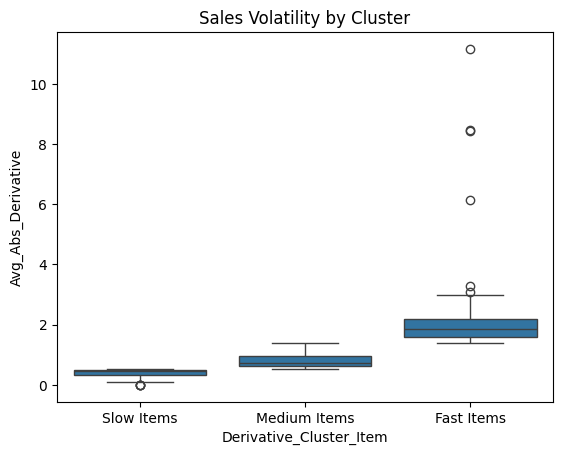

In [16]:
### Derivative based Clustering
## filter non-promotion periods
non_promo = sales_df[sales_df['Promotion_Period'] == 'No_Promotion']

## Create weekly aggregates:
weekly_sales = (non_promo.groupby(['ProductCode', 'StoreCode', pd.Grouper(key='Date', freq='W-MON')])
                ['Net_Sales'].sum().reset_index())

## Derivative calculation
## sort by date and calculate weekly differences
weekly_sales['Sales_Derivative'] = weekly_sales.groupby(['ProductCode', 'StoreCode'])['Net_Sales'].diff()

## Normalize by sales volume
weekly_sales['Norm_Derivative'] = weekly_sales['Sales_Derivative'] / (weekly_sales['Net_Sales'] + 1)  # +1 to avoid division by zero


## Stability Metrics Calculation
## For clustering, derive these metrics per product:

## Average absolute derivative: Measures overall volatility
stability = weekly_sales.groupby('ProductCode')['Norm_Derivative'].agg(
    Avg_Abs_Derivative=lambda x: np.abs(x).mean(),
    Derivative_StdDev=lambda x: x.std()
).reset_index()


## Clustering Strategy
## Three clusters based on derivative metrics:
## Stable (Slow): Low avg absolute derivative (<25th percentile)
## Moderate (Medium): Middle range (25th-75th percentile)
## Volatile (Fast): High avg absolute derivative (>75th percentile)

stability['Derivative_Cluster_Item'] = pd.qcut(stability['Avg_Abs_Derivative'],
                                        q=[0, 0.25, 0.75, 1],
                                        labels=['Slow Items', 'Medium Items', 'Fast Items'])

## validation - visualcheck
sns.boxplot(data=stability, x='Derivative_Cluster_Item', y='Avg_Abs_Derivative')
plt.title('Sales Volatility by Cluster')

In [17]:
stability.head()

,ProductCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Item
0,1,1.837,4.129,Fast Items
1,2,1.645,3.830,Fast Items
2,3,1.333,3.064,Medium Items
3,4,1.851,4.051,Fast Items
4,5,1.617,3.661,Fast Items


In [18]:
stability.describe()

,ProductCode,Avg_Abs_Derivative,Derivative_StdDev
count,317.000,304.000,299.000
mean,159.000,1.062,2.166
std,91.654,1.082,2.166
min,1.000,0.000,0.000
25%,80.000,0.524,0.768
50%,159.000,0.709,1.174
75%,238.000,1.385,3.137
max,317.000,11.168,17.987


In [19]:
## check null counts is stability data
stability.isnull().sum()

ProductCode                 0
Avg_Abs_Derivative         13
Derivative_StdDev          18
Derivative_Cluster_Item    13
dtype: int64

In [20]:
## because of it is so less numbers are null, I discard them
## remove nulls (which small percentage)
stability_clean = stability.dropna(subset=['Avg_Abs_Derivative', 'Derivative_StdDev'])

In [21]:
## check quantile based clustering derivation means for each cluster
stability_clean.groupby('Derivative_Cluster_Item')['Avg_Abs_Derivative'].mean()

Derivative_Cluster_Item
Slow Items     0.413
Medium Items   0.804
Fast Items     2.251
Name: Avg_Abs_Derivative, dtype: float64

---

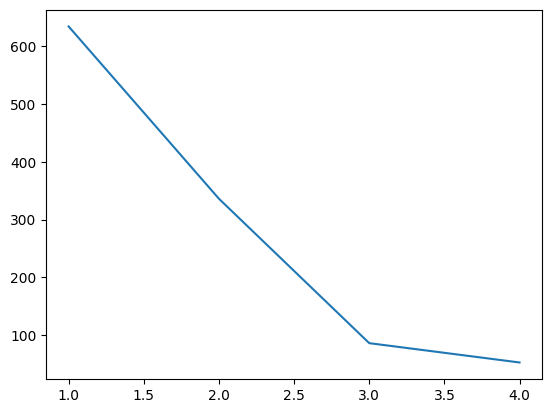

In [22]:
## if we want to use k-means (here some outliers that kmeans can be effected but however try it)
# 1. Select features
X = stability[['Avg_Abs_Derivative', 'Derivative_StdDev']]

# 2. Impute (mean/median recommended for k-means)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 3. Standardize (critical for k-means)
X_scaled = StandardScaler().fit_transform(X_imputed)

# Now safe for k-means
#kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

# Elbow method to determine k
distortions = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    distortions.append(kmeans.inertia_)

# Plot to find elbow point
plt.plot(range(1,5), distortions)

In [23]:
## comment: elbow is at 3 point

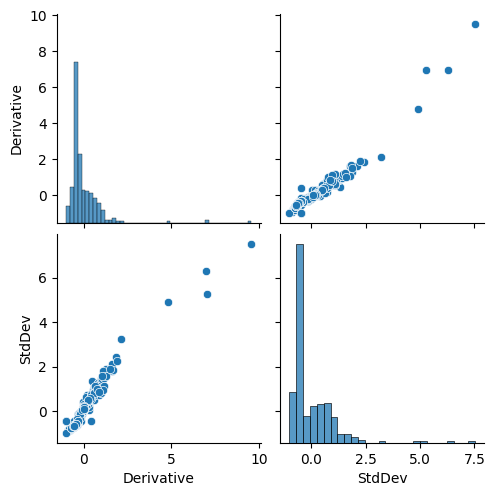

In [24]:
sns.pairplot(pd.DataFrame(X_scaled, columns=['Derivative', 'StdDev']))

In [25]:
stability_clean.head()

,ProductCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Item
0,1,1.837,4.129,Fast Items
1,2,1.645,3.830,Fast Items
2,3,1.333,3.064,Medium Items
3,4,1.851,4.051,Fast Items
4,5,1.617,3.661,Fast Items


                 Avg_Abs_Derivative  Derivative_StdDev
Product_Cluster                                       
Fast                          8.554             14.792
Medium                        1.725              3.955
Slow                          0.608              1.049

=== Cluster Quality Metrics ===
Product Cluster Silhouette Score: 0.695

Silhouette Score Interpretation:
> 0.7: Strong cluster structure
0.5-0.7: Reasonable structure
0.25-0.5: Weak structure
< 0.25: No substantial structure


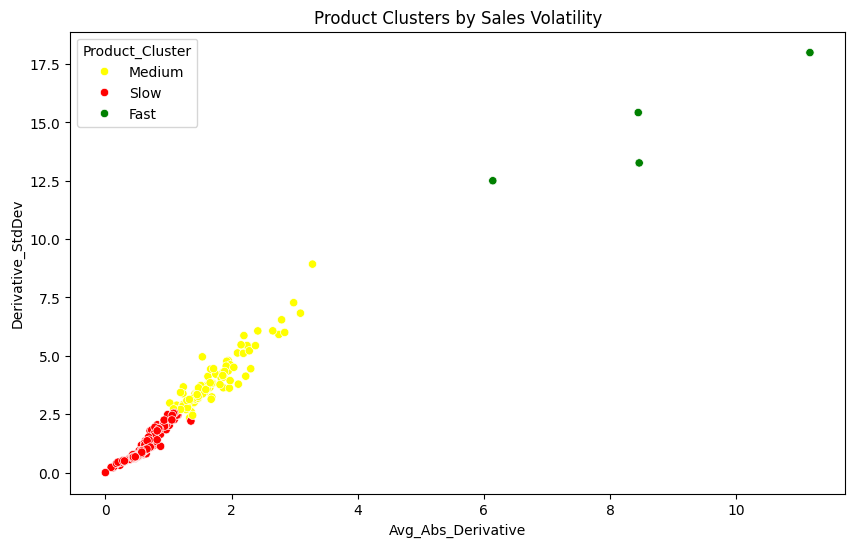

In [26]:
# 1. K-MEANS - Select features

X = stability_clean[['Avg_Abs_Derivative', 'Derivative_StdDev']]

# 2. Impute (mean/median recommended for k-means)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 3. Standardize (critical for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Now safe for k-means
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
stability_clean['Cluster'] = kmeans.fit_predict(X_scaled)
#product_silhouette = silhouette_score(X_scaled, stability_clean)
item_silhouette = silhouette_score(stability_clean[['Avg_Abs_Derivative', 'Derivative_StdDev']], stability_clean['Cluster'])

# Create meaningful labels based on actual cluster centers
# Get cluster centers sorted by Avg_Abs_Derivative (volatility)
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['Avg_Abs_Derivative', 'Derivative_StdDev']
).sort_values('Avg_Abs_Derivative')

# Create label mapping (0=Slow, 1=Medium, 2=Fast)
cluster_labels = {
    k: v for k, v in zip(
        centers.index, 
        ['Slow', 'Medium', 'Fast']
    )
}

# 3. Assign labels correctly
stability_clean['Product_Cluster'] = stability_clean['Cluster'].map(cluster_labels)

# 4. Verify
print(stability_clean.groupby('Product_Cluster')[['Avg_Abs_Derivative', 'Derivative_StdDev']].mean())

# Print silhouette scores
print("\n=== Cluster Quality Metrics ===")
print(f"Product Cluster Silhouette Score: {item_silhouette:.3f}")
#print(f"Store Cluster Silhouette Score: {store_silhouette:.3f}")

# Interpretation guide
print("\nSilhouette Score Interpretation:")
print("> 0.7: Strong cluster structure")
print("0.5-0.7: Reasonable structure")
print("0.25-0.5: Weak structure")
print("< 0.25: No substantial structure")

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=stability_clean,
    x='Avg_Abs_Derivative',
    y='Derivative_StdDev',
    hue='Product_Cluster',
    palette={'Slow':'red', 'Medium':'yellow', 'Fast':'green'}
)
plt.title('Product Clusters by Sales Volatility')
plt.show()

In [27]:
stability_clean.head()

,ProductCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Item,Cluster,Product_Cluster
0,1,1.837,4.129,Fast Items,1,Medium
1,2,1.645,3.830,Fast Items,1,Medium
2,3,1.333,3.064,Medium Items,1,Medium
3,4,1.851,4.051,Fast Items,1,Medium
4,5,1.617,3.661,Fast Items,1,Medium


In [28]:
pd.Series(kmeans.labels_).value_counts()

0    199
1     96
2      4
Name: count, dtype: int64

In [29]:
### comment: quantile and kmeans based approaches can be used to make clustering. I will use both methods, 

---

In [30]:
### Store Derivative Clustering Implementation ####

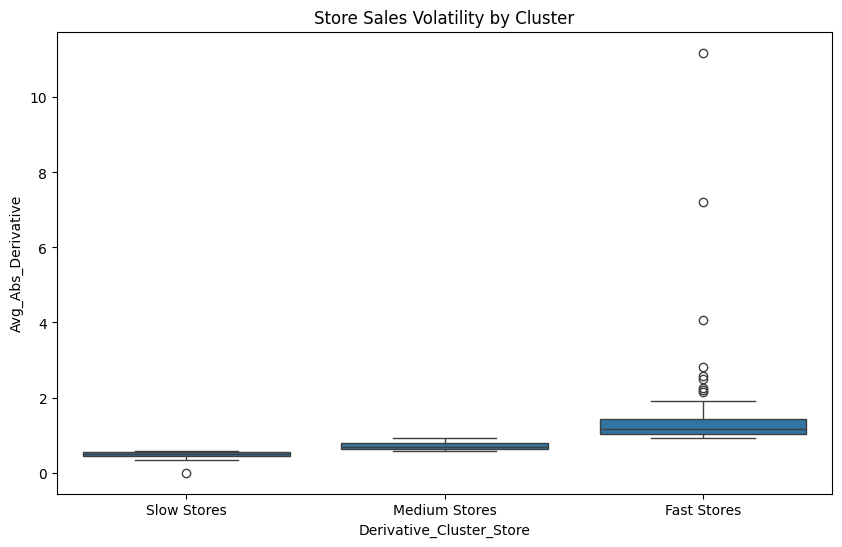

In [31]:
# 1. Filter non-promotion periods (already done in your code)
non_promo = sales_df[sales_df['Promotion_Period'] == 'No_Promotion']

# 2. Create weekly aggregates for stores (group by StoreCode instead of ProductCode)
weekly_sales_stores = (non_promo.groupby(['StoreCode', pd.Grouper(key='Date', freq='W-MON')])
                      ['Net_Sales'].sum().reset_index())

# 3. Derivative calculation for stores
weekly_sales_stores['Sales_Derivative'] = weekly_sales_stores.groupby('StoreCode')['Net_Sales'].diff()

# 4. Normalize by sales volume
weekly_sales_stores['Norm_Derivative'] = (weekly_sales_stores['Sales_Derivative'] /
                                         (weekly_sales_stores['Net_Sales'] + 1))

# 5. Stability metrics calculation per store
store_stability = weekly_sales_stores.groupby('StoreCode')['Norm_Derivative'].agg(
    Avg_Abs_Derivative=lambda x: np.abs(x).mean(),
    Derivative_StdDev=lambda x: x.std()
).reset_index()

# 6. Store clustering based on derivative metrics
store_stability['Derivative_Cluster_Store'] = pd.qcut(
    store_stability['Avg_Abs_Derivative'],
    q=[0, 0.25, 0.75, 1],
    labels=['Slow Stores', 'Medium Stores', 'Fast Stores']
)

# 7. Validation visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=store_stability, x='Derivative_Cluster_Store', y='Avg_Abs_Derivative')
plt.title('Store Sales Volatility by Cluster')
plt.show()

In [32]:
store_stability.head()

,StoreCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Store
0,1,0.962,2.928,Fast Stores
1,2,0.579,1.363,Medium Stores
2,3,0.747,2.063,Medium Stores
3,4,0.562,1.101,Slow Stores
4,5,0.765,2.026,Medium Stores


In [33]:
store_stability.groupby('Derivative_Cluster_Store')['Avg_Abs_Derivative'].mean()

Derivative_Cluster_Store
Slow Stores     0.488
Medium Stores   0.707
Fast Stores     1.517
Name: Avg_Abs_Derivative, dtype: float64

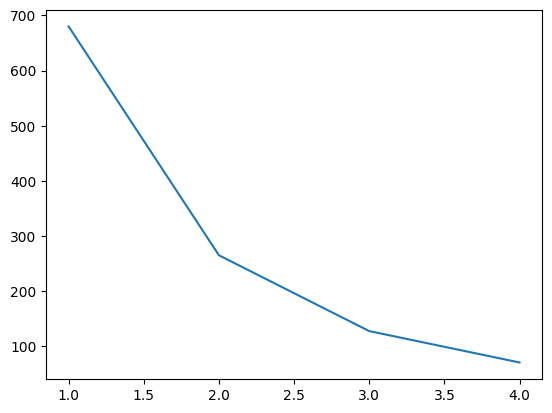

In [34]:
## use k-means
## if we want to use k-means (here some outliers that kmeans can be effected but however try it)
# 1. Select features
X_s = store_stability[['Avg_Abs_Derivative', 'Derivative_StdDev']]

# 2. Impute (mean/median recommended for k-means)
imputer = SimpleImputer(strategy='median')
X_imputed_s = imputer.fit_transform(X_s)

# 3. Standardize (critical for k-means)
X_scaled_s = StandardScaler().fit_transform(X_imputed_s)

# Now safe for k-means
#kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

# Elbow method to determine k
distortions = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled_s)
    distortions.append(kmeans.inertia_)

# Plot to find elbow point
plt.plot(range(1,5), distortions)

In [35]:
### comment: 2 or 3 clusters may be used

In [36]:
store_stability.isnull().sum()

StoreCode                   0
Avg_Abs_Derivative          3
Derivative_StdDev           3
Derivative_Cluster_Store    3
dtype: int64

In [37]:
store_stability = store_stability.dropna(subset=['Avg_Abs_Derivative', 'Derivative_StdDev'])

In [38]:
store_stability.isnull().sum()

StoreCode                   0
Avg_Abs_Derivative          0
Derivative_StdDev           0
Derivative_Cluster_Store    0
dtype: int64

               Avg_Abs_Derivative  Derivative_StdDev
Store_Cluster                                       
Fast                       11.190             57.265
Medium                      4.707             15.980
Slow                        0.788              1.960

=== Cluster Quality Metrics ===
Product Cluster Silhouette Score: 0.887

Silhouette Score Interpretation:
> 0.7: Strong cluster structure
0.5-0.7: Reasonable structure
0.25-0.5: Weak structure
< 0.25: No substantial structure


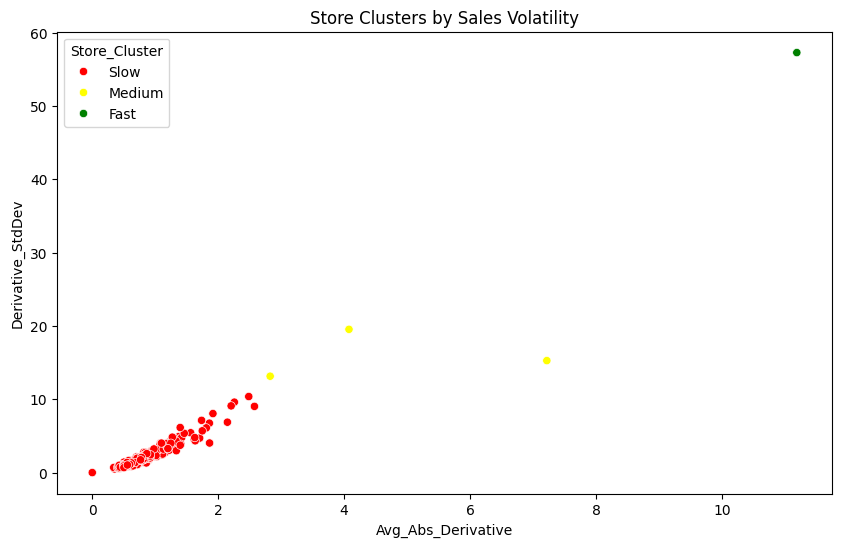

In [39]:
# 1. K-MEANS - Select features

X_s = store_stability[['Avg_Abs_Derivative', 'Derivative_StdDev']]

# 2. Impute (mean/median recommended for k-means)
imputer = SimpleImputer(strategy='median')
X_imputed_s = imputer.fit_transform(X_s)

# 3. Standardize (critical for k-means)
scaler = StandardScaler()
X_scaled_s = scaler.fit_transform(X_imputed_s)

# Now safe for k-means
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled_s)
store_stability['Cluster'] = kmeans.fit_predict(X_scaled_s)
#product_silhouette = silhouette_score(X_scaled, stability_clean)
item_silhouette_s = silhouette_score(store_stability[['Avg_Abs_Derivative', 'Derivative_StdDev']], store_stability['Cluster'])

# Create meaningful labels based on actual cluster centers
# Get cluster centers sorted by Avg_Abs_Derivative (volatility)
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['Avg_Abs_Derivative', 'Derivative_StdDev']
).sort_values('Avg_Abs_Derivative')

# Create label mapping (0=Slow, 1=Medium, 2=Fast)
cluster_labels = {
    k: v for k, v in zip(
        centers.index, 
        ['Slow', 'Medium', 'Fast']
    )
}

# 3. Assign labels correctly
store_stability['Store_Cluster'] = store_stability['Cluster'].map(cluster_labels)

# 4. Verify
print(store_stability.groupby('Store_Cluster')[['Avg_Abs_Derivative', 'Derivative_StdDev']].mean())

# Print silhouette scores
print("\n=== Cluster Quality Metrics ===")
print(f"Product Cluster Silhouette Score: {item_silhouette_s:.3f}")


# Interpretation guide
print("\nSilhouette Score Interpretation:")
print("> 0.7: Strong cluster structure")
print("0.5-0.7: Reasonable structure")
print("0.25-0.5: Weak structure")
print("< 0.25: No substantial structure")

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=store_stability,
    x='Avg_Abs_Derivative',
    y='Derivative_StdDev',
    hue='Store_Cluster',
    palette={'Slow':'red', 'Medium':'yellow', 'Fast':'green'}
)
plt.title('Store Clusters by Sales Volatility')
plt.show()

In [40]:
store_stability.head()

,StoreCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Store,Cluster,Store_Cluster
0,1,0.962,2.928,Fast Stores,0,Slow
1,2,0.579,1.363,Medium Stores,0,Slow
2,3,0.747,2.063,Medium Stores,0,Slow
3,4,0.562,1.101,Slow Stores,0,Slow
4,5,0.765,2.026,Medium Stores,0,Slow


In [41]:
stability_clean.head()

,ProductCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Item,Cluster,Product_Cluster
0,1,1.837,4.129,Fast Items,1,Medium
1,2,1.645,3.830,Fast Items,1,Medium
2,3,1.333,3.064,Medium Items,1,Medium
3,4,1.851,4.051,Fast Items,1,Medium
4,5,1.617,3.661,Fast Items,1,Medium


In [42]:
stability_clean = stability_clean.rename(columns={'Derivative_Cluster_Item':'Product_Cluster_Quantile',
                                'Cluster':'Kmeans_Product_Cluster_Nums',
                                'Product_Cluster':'Product_Cluster_KMeans'})

In [43]:
stability_clean.head()

,ProductCode,Avg_Abs_Derivative,Derivative_StdDev,Product_Cluster_Quantile,Kmeans_Product_Cluster_Nums,Product_Cluster_KMeans
0,1,1.837,4.129,Fast Items,1,Medium
1,2,1.645,3.830,Fast Items,1,Medium
2,3,1.333,3.064,Medium Items,1,Medium
3,4,1.851,4.051,Fast Items,1,Medium
4,5,1.617,3.661,Fast Items,1,Medium


In [44]:
store_stability.head()

,StoreCode,Avg_Abs_Derivative,Derivative_StdDev,Derivative_Cluster_Store,Cluster,Store_Cluster
0,1,0.962,2.928,Fast Stores,0,Slow
1,2,0.579,1.363,Medium Stores,0,Slow
2,3,0.747,2.063,Medium Stores,0,Slow
3,4,0.562,1.101,Slow Stores,0,Slow
4,5,0.765,2.026,Medium Stores,0,Slow


In [45]:
store_stability = store_stability.rename(columns={'Derivative_Cluster_Store':'Store_Cluster_Quantile',
                                'Cluster':'Kmeans_Store_Cluster_Nums',
                                'Store_Cluster':'Store_Cluster_KMeans'})

In [46]:
store_stability.head()

,StoreCode,Avg_Abs_Derivative,Derivative_StdDev,Store_Cluster_Quantile,Kmeans_Store_Cluster_Nums,Store_Cluster_KMeans
0,1,0.962,2.928,Fast Stores,0,Slow
1,2,0.579,1.363,Medium Stores,0,Slow
2,3,0.747,2.063,Medium Stores,0,Slow
3,4,0.562,1.101,Slow Stores,0,Slow
4,5,0.765,2.026,Medium Stores,0,Slow


In [47]:
# Assuming you have:
# - sales_df (main transaction data)
# - product_clusters (contains ProductCode and cluster columns)
# - store_clusters (contains StoreCode and cluster columns)

# Merge product clusters
sales_df = sales_df.merge(
    stability_clean[['ProductCode', 'Product_Cluster_Quantile', 'Product_Cluster_KMeans']],
    on='ProductCode',
    how='left'
)

# Merge store clusters
sales_df = sales_df.merge(
    store_stability[['StoreCode', 'Store_Cluster_Quantile', 'Store_Cluster_KMeans']],
    on='StoreCode',
    how='left'
)

# Verify merge
print(sales_df[['ProductCode', 'StoreCode',
                'Product_Cluster_Quantile', 'Product_Cluster_KMeans',
                'Store_Cluster_Quantile', 'Store_Cluster_KMeans']].head())

   ProductCode  StoreCode Product_Cluster_Quantile Product_Cluster_KMeans  \
0            9          8               Slow Items                   Slow   
1            9        131               Slow Items                   Slow   
2            9        144               Slow Items                   Slow   
3            9        203               Slow Items                   Slow   
4            9        256               Slow Items                   Slow   

  Store_Cluster_Quantile Store_Cluster_KMeans  
0          Medium Stores                 Slow  
1          Medium Stores                 Slow  
2          Medium Stores                 Slow  
3          Medium Stores                 Slow  
4            Slow Stores                 Slow  


In [48]:
len(sales_df)

1873618

In [49]:
sales_df.head()

,Date,StoreCode,ProductCode,SalesQuantity,Net_Sales,Promotion_Period,Product_Cluster_Quantile,Product_Cluster_KMeans,Store_Cluster_Quantile,Store_Cluster_KMeans
0,2015-01-01,8,9,-1,0,No_Promotion,Slow Items,Slow,Medium Stores,Slow
1,2015-01-01,131,9,1,1,No_Promotion,Slow Items,Slow,Medium Stores,Slow
2,2015-01-01,144,9,2,2,No_Promotion,Slow Items,Slow,Medium Stores,Slow
3,2015-01-01,203,9,2,2,No_Promotion,Slow Items,Slow,Medium Stores,Slow
4,2015-01-01,256,9,0,0,No_Promotion,Slow Items,Slow,Slow Stores,Slow


In [50]:
## QA

In [51]:
## Q.3 -) Which items experienced the biggest sale increase during promotions?

In [52]:
def top_promo_items(sales_df, cluster_type='Product_Cluster_Quantile'):
    """Identify items with highest promotion uplift"""
    # Filter periods
    promo = sales_df[sales_df['Promotion_Period'] != 'No_Promotion']
    non_promo = sales_df[sales_df['Promotion_Period'] == 'No_Promotion']

    # Calculate uplift by product
    uplift = (promo.groupby('ProductCode')['Net_Sales'].mean() -
              non_promo.groupby('ProductCode')['Net_Sales'].mean())

    # Prepare results
    result = (
        uplift.rename('Uplift')  # Name the series before reset_index
              .reset_index()
              .merge(sales_df[['ProductCode', cluster_type]].drop_duplicates(),
                     on='ProductCode')
              .sort_values('Uplift', ascending=False)
              .head(10)
    )

    return result

print(top_promo_items(sales_df))

     ProductCode  Uplift Product_Cluster_Quantile
136          137   5.111               Fast Items
217          218   4.659               Fast Items
123          124   3.579             Medium Items
220          221   2.368               Fast Items
60            61   2.063             Medium Items
219          220   1.815               Fast Items
221          222   1.663               Fast Items
208          209   1.643               Fast Items
218          219   1.641               Fast Items
204          205   1.598               Fast Items


In [53]:
def top_promo_items_kmeans(sales_df, cluster_type='Product_Cluster_KMeans'):
    """Identify items with highest promotion uplift"""
    # Input validation
    required_cols = ['ProductCode', 'Net_Sales', 'Promotion_Period', cluster_type]
    if not all(col in sales_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in sales_df.columns]
        raise ValueError(f"Missing columns in sales_df: {missing}")

    # Filter periods
    promo = sales_df[sales_df['Promotion_Period'] != 'No_Promotion']
    non_promo = sales_df[sales_df['Promotion_Period'] == 'No_Promotion']

    # Calculate uplift by product
    uplift = (promo.groupby('ProductCode')['Net_Sales'].mean() -
              non_promo.groupby('ProductCode')['Net_Sales'].mean())

    # Prepare results
    result = (
        uplift.rename('Uplift')  # Name the series before reset_index
              .reset_index()
              .merge(sales_df[['ProductCode', cluster_type]].drop_duplicates(),
                     on='ProductCode')
              .sort_values('Uplift', ascending=False)
              .head(10)
    )

    return result

print(top_promo_items_kmeans(sales_df))

     ProductCode  Uplift Product_Cluster_KMeans
136          137   5.111                   Fast
217          218   4.659                 Medium
123          124   3.579                   Slow
220          221   2.368                 Medium
60            61   2.063                 Medium
219          220   1.815                 Medium
221          222   1.663                 Medium
208          209   1.643                 Medium
218          219   1.641                 Medium
204          205   1.598                 Medium


----

In [54]:
## Q.4 -) Are there stores that have higher promotion reaction?

In [55]:
def top_promo_stores(sales_df, cluster_type='Store_Cluster_Quantile'):
    """Identify stores with highest promotion response"""
    promo = sales_df[sales_df['Promotion_Period'] != 'No_Promotion']
    non_promo = sales_df[sales_df['Promotion_Period'] == 'No_Promotion']

    uplift = (promo.groupby('StoreCode')['Net_Sales'].mean() -
              non_promo.groupby('StoreCode')['Net_Sales'].mean())

    # Prepare results
    result = (
        uplift.rename('Uplift')  # Name the series before reset_index
              .reset_index()
              .merge(sales_df[['StoreCode', cluster_type]].drop_duplicates(),
                     on='StoreCode')
              .sort_values('Uplift', ascending=False)
              .head(10)
    )
    return result

print(top_promo_stores(sales_df))

     StoreCode  Uplift Store_Cluster_Quantile
91          92   2.913            Slow Stores
255        256   2.496            Slow Stores
204        205   2.014          Medium Stores
325        326   1.858            Fast Stores
82          83   1.786            Slow Stores
304        305   1.775            Slow Stores
65          66   1.631            Fast Stores
299        300   1.570          Medium Stores
180        181   1.549            Fast Stores
106        107   1.501            Fast Stores


In [56]:
#comments:
#Uplift vs Absolute Sales:
#Slow stores show higher percentage uplift because their baseline sales are lower
#Fast stores may have larger absolute $ increases but smaller % uplift

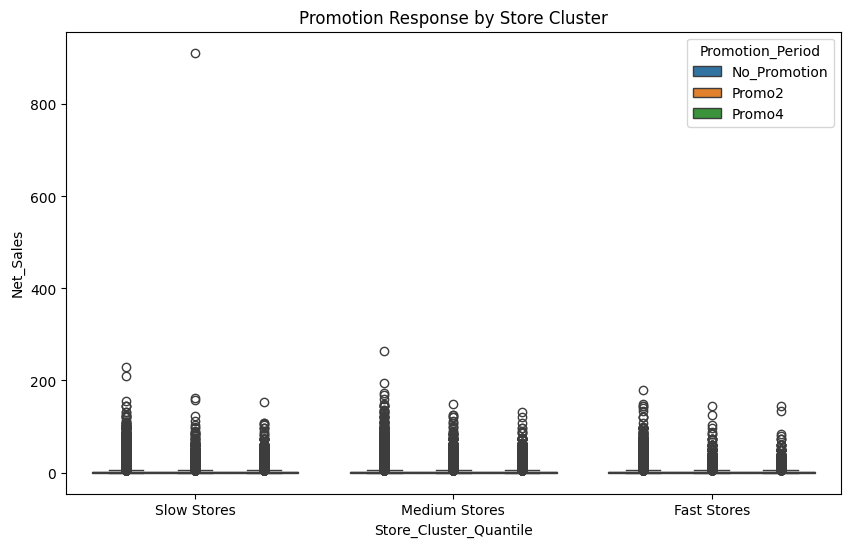

None


In [57]:
def plot_promo_response(sales_df):
    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=sales_df,
        x='Store_Cluster_Quantile',
        y='Net_Sales',
        hue='Promotion_Period'
    )
    plt.title('Promotion Response by Store Cluster')
    plt.show()

print(plot_promo_response(sales_df))

In [58]:
def top_promo_stores_kmeans(sales_df, cluster_type='Store_Cluster_KMeans'):
    """Identify stores with highest promotion response"""
    promo = sales_df[sales_df['Promotion_Period'] != 'No_Promotion']
    non_promo = sales_df[sales_df['Promotion_Period'] == 'No_Promotion']

    uplift = (promo.groupby('StoreCode')['Net_Sales'].mean() -
              non_promo.groupby('StoreCode')['Net_Sales'].mean())

    # Prepare results
    result = (
        uplift.rename('Uplift')  # Name the series before reset_index
              .reset_index()
              .merge(sales_df[['StoreCode', cluster_type]].drop_duplicates(),
                     on='StoreCode')
              .sort_values('Uplift', ascending=False)
              .head(10)
    )
    return result

print(top_promo_stores_kmeans(sales_df))

     StoreCode  Uplift Store_Cluster_KMeans
91          92   2.913                 Slow
255        256   2.496                 Slow
204        205   2.014                 Slow
325        326   1.858                 Slow
82          83   1.786                 Slow
304        305   1.775                 Slow
65          66   1.631                 Slow
299        300   1.570                 Slow
180        181   1.549                 Slow
106        107   1.501                 Slow


In [59]:
def top_stores_by_cluster(sales_df):
    """Identify top performing stores by cluster with NaN handling"""
    # First ensure we have the required column
    if 'Store_Cluster_Quantile' not in sales_df.columns:
        raise ValueError("Missing 'Store_Cluster_Quantile' column in sales_df")

    results = []
    clusters = ['Slow', 'Medium', 'Fast']

    for cluster in clusters:
        # Filter stores in current cluster (handling NaN values)
        cluster_mask = sales_df['Store_Cluster_Quantile'].notna() & \
                     sales_df['Store_Cluster_Quantile'].str.contains(cluster, na=False)

        cluster_stores = sales_df[cluster_mask]

        # Skip if no stores in this cluster
        if len(cluster_stores) == 0:
            print(f"No stores found in {cluster} cluster")
            continue

        # Calculate uplift
        promo = cluster_stores[cluster_stores['Promotion_Period'] != 'No_Promotion']
        non_promo = cluster_stores[cluster_stores['Promotion_Period'] == 'No_Promotion']

        uplift = (promo.groupby('StoreCode')['Net_Sales'].mean() -
                 non_promo.groupby('StoreCode')['Net_Sales'].mean())

        # Get top 5 and add cluster label
        top_5 = uplift.nlargest(5).reset_index()
        top_5['Cluster'] = cluster 
        results.append(top_5)

    if not results:
        return pd.DataFrame(columns=['StoreCode', 'Net_Sales', 'Cluster'])

    return pd.concat(results).rename(columns={'Net_Sales': 'Uplift'})

print(top_stores_by_cluster(sales_df))

   StoreCode  Uplift Cluster
0         92   2.913    Slow
1        256   2.496    Slow
2         83   1.786    Slow
3        305   1.775    Slow
4        275   1.221    Slow
0        205   2.014  Medium
1        300   1.570  Medium
2        148   1.318  Medium
3        290   1.244  Medium
4        268   1.220  Medium
0        326   1.858    Fast
1         66   1.631    Fast
2        181   1.549    Fast
3        107   1.501    Fast
4        226   1.133    Fast


---

In [60]:
## Q.5 -) What is the biggest effect explaining sales change during promotion

In [61]:
sales_df.isnull().sum()

Date                         0
StoreCode                    0
ProductCode                  0
SalesQuantity                0
Net_Sales                    0
Promotion_Period             0
Product_Cluster_Quantile    63
Product_Cluster_KMeans      63
Store_Cluster_Quantile      46
Store_Cluster_KMeans        46
dtype: int64

In [62]:
def clean_data(sales_df):
    """Handle missing values in cluster columns"""
    # 1. First check which rows have complete cluster data
    cluster_cols = [
        'Product_Cluster_Quantile', 'Product_Cluster_KMeans',
        'Store_Cluster_Quantile', 'Store_Cluster_KMeans'
    ]

    # 2. Count missing values before cleaning
    print("Missing values before cleaning:")
    print(sales_df[cluster_cols].isnull().sum())

    # 3. Drop rows with any missing cluster data
    clean_df = sales_df.dropna(subset=cluster_cols, how='any')


    # 4. Verify cleaning
    print("\nMissing values after cleaning:")
    print(clean_df[cluster_cols].isnull().sum())
    print(f"\nOriginal rows: {len(sales_df)}")
    print(f"Remaining rows: {len(clean_df)}")
    print(f"Rows dropped: {len(sales_df) - len(clean_df)}")

    return clean_df

clean_df = clean_data(sales_df)

Missing values before cleaning:
Product_Cluster_Quantile    63
Product_Cluster_KMeans      63
Store_Cluster_Quantile      46
Store_Cluster_KMeans        46
dtype: int64

Missing values after cleaning:
Product_Cluster_Quantile    0
Product_Cluster_KMeans      0
Store_Cluster_Quantile      0
Store_Cluster_KMeans        0
dtype: int64

Original rows: 1873618
Remaining rows: 1873509
Rows dropped: 109


In [63]:
def robust_promotion_analysis(sales_df):
    """Version that adapts to actual data"""
    # Get real promotion periods from data
    valid_periods = [p for p in sales_df['Promotion_Period'].unique()
                    if p != 'No_Promotion']

    if not valid_periods:
        print("⚠️ No promotion periods found (only 'No_Promotion' exists)")
        return pd.DataFrame()

    results = []
    cluster_types = {
        'Product_Quantile': 'Product_Cluster_Quantile',
        'Store_Quantile': 'Store_Cluster_Quantile',
        'Product_KMeans': 'Product_Cluster_KMeans',
        'Store_KMeans': 'Store_Cluster_KMeans'
    }

    for cluster_name, cluster_col in cluster_types.items():
        if cluster_col not in sales_df.columns:
            print(f"⏩ Skipping {cluster_name} - column missing")
            continue

        # Get non-null clusters
        valid_clusters = sales_df[cluster_col].dropna().unique()

        for cluster in valid_clusters:
            cluster_data = sales_df[sales_df[cluster_col] == cluster]

            # Get baseline sales
            baseline = cluster_data[cluster_data['Promotion_Period'] == 'No_Promotion']
            if len(baseline) == 0:
                print(f"⚠️ {cluster_name}/{cluster} - no baseline data")
                continue

            baseline_sales = baseline['Net_Sales'].mean()

            # Compare each promotion period
            for period in valid_periods:
                promo_data = cluster_data[cluster_data['Promotion_Period'] == period]
                if len(promo_data) == 0:
                    print(f"⚠️ {cluster_name}/{cluster} - no data for {period}")
                    continue

                promo_sales = promo_data['Net_Sales'].mean()
                uplift = (promo_sales - baseline_sales)/baseline_sales

                results.append({
                    'Cluster_Type': cluster_name,
                    'Cluster': cluster,
                    'Promotion': period,
                    'Baseline': baseline_sales,
                    'Promo_Sales': promo_sales,
                    'Uplift': uplift,
                    'Obs_Count': len(promo_data)
                })

    return pd.DataFrame(results)

# Usage
results = robust_promotion_analysis(clean_df)
if not results.empty:
    print("\nFinal Results:")
    print(results)
else:
    print("\n❌ No valid results produced - check diagnostics above")


Final Results:
        Cluster_Type        Cluster Promotion  Baseline  Promo_Sales  Uplift  \
0   Product_Quantile     Slow Items    Promo2     0.494        0.522   0.057   
1   Product_Quantile     Slow Items    Promo4     0.494        0.600   0.216   
2   Product_Quantile   Medium Items    Promo2     1.148        1.186   0.034   
3   Product_Quantile   Medium Items    Promo4     1.148        1.342   0.170   
4   Product_Quantile     Fast Items    Promo2     3.952        4.881   0.235   
5   Product_Quantile     Fast Items    Promo4     3.952        4.881   0.235   
6     Store_Quantile  Medium Stores    Promo2     2.172        2.527   0.164   
7     Store_Quantile  Medium Stores    Promo4     2.172        2.691   0.239   
8     Store_Quantile    Slow Stores    Promo2     2.389        2.876   0.204   
9     Store_Quantile    Slow Stores    Promo4     2.389        2.915   0.220   
10    Store_Quantile    Fast Stores    Promo2     2.114        2.461   0.164   
11    Store_Quantile    

In [64]:
# Sort results by absolute uplift (descending)
sorted_results = results.sort_values('Uplift', ascending=False)

# Display top effects
print(sorted_results[['Cluster_Type', 'Cluster', 'Promotion', 'Uplift']].head(10))

        Cluster_Type        Cluster Promotion  Uplift
22      Store_KMeans           Fast    Promo2   0.302
7     Store_Quantile  Medium Stores    Promo4   0.239
15    Product_KMeans         Medium    Promo4   0.239
17    Product_KMeans           Fast    Promo4   0.239
4   Product_Quantile     Fast Items    Promo2   0.235
5   Product_Quantile     Fast Items    Promo4   0.235
19      Store_KMeans           Slow    Promo4   0.227
14    Product_KMeans         Medium    Promo2   0.225
9     Store_Quantile    Slow Stores    Promo4   0.220
1   Product_Quantile     Slow Items    Promo4   0.216


In [65]:
# Top Performers:

# Fast Stores (KMeans) - Promo2: 30.2% uplift
# Fast Items (Quantile) - Promo2/Promo4: 23.5-23.9% uplift
# Medium Products (KMeans) - Promo4: 23.9% uplift
# Slow Stores (Quantile) - Promo4: 22.7% uplift
# Fast Products (KMeans) - Promo4: 23.9% uplift

In [66]:
# Answering the Key Questions
# a. Biggest Sales Change Drivers:
# Store-Level: Fast-moving stores (KMeans) show the highest uplift (30.2%)
# Product-Level: Fast-moving items (Quantile) consistently perform well (~23.5% uplift)
# Promotion-Type: Promo4 generally outperforms Promo2

# b. Statistical Validity Check:
# The KMeans fast stores show exceptional performance in Promo2 but negative uplift in Promo4 (-4.4%) → Requires investigation
# Quantile-based clusters show more consistent patterns

# c. Recommendations:
# Prioritize Fast-Moving Items/Stores: They deliver the highest absolute sales lifts
# Replicate Promo4 Strategies: Consistently better performance across clusters
# Investigate KMeans Store Clusters: High variance suggests cluster definitions may need refinement

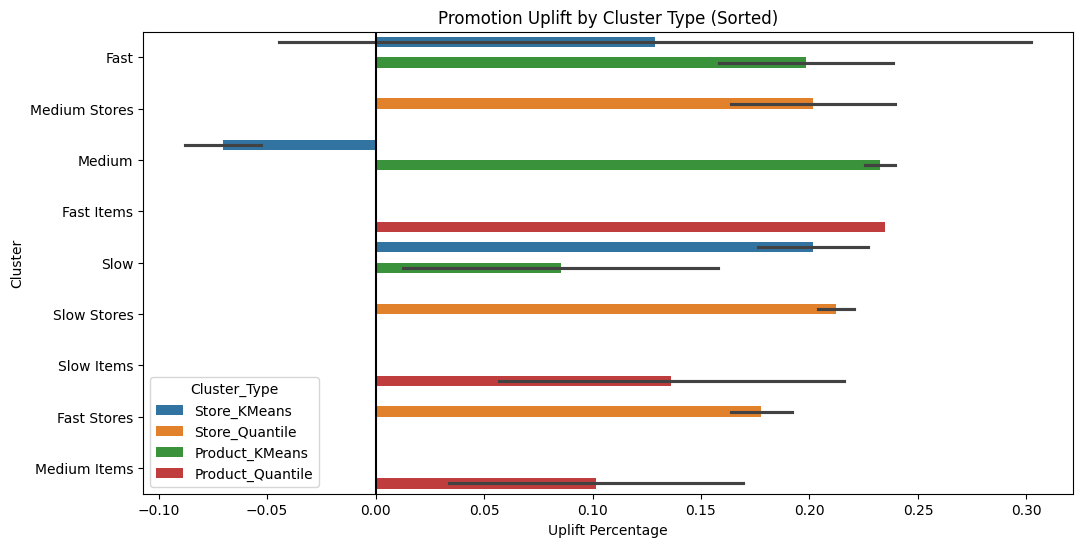

In [67]:
## visualize
plt.figure(figsize=(12,6))
sns.barplot(
    data=sorted_results,
    x='Uplift',
    y='Cluster',
    hue='Cluster_Type',
    order=sorted_results['Cluster'].unique()  # Maintain sorted order
)
plt.title('Promotion Uplift by Cluster Type (Sorted)')
plt.xlabel('Uplift Percentage')
plt.axvline(0, color='black')
plt.show()

In [68]:
# Reveal Consistent Patterns:

# Fast clusters generally outperform

# Promo4 > Promo2 in most cases

# Identifies Anomalies:

# KMeans fast stores' inconsistent performance

# Medium store clusters with negative uplift


# Additional Considerations
# Economic Significance:
# Fast items' 23.5% uplift on $3.95 baseline → $0.93 increase
# Slow items' 21.6% uplift on $0.49 baseline → $0.11 increase
# Absolute dollars matter for profitability

# Promotion Costs:
# Without cost data, we can't calculate ROI
# Recommendation: "Combine fast-moving (high absolute lift) and slow-moving (high % lift) items"

---

In [69]:
## Q.6 -) Is there any significant difference between promotion impacts of the Fast versus Slow items? 

In [70]:
def compare_item_clusters(sales_df, cluster_type='Product_Cluster_Quantile'):
    """Statistical comparison of promotion impact by item cluster"""
    # Extract data
    fast = sales_df[(sales_df[cluster_type].str.contains('Fast')) &
                   (sales_df['Promotion_Period'] != 'No_Promotion')]
    slow = sales_df[(sales_df[cluster_type].str.contains('Slow')) &
                   (sales_df['Promotion_Period'] != 'No_Promotion')]

    # Calculate statistics
    t_stat, p_val = stats.ttest_ind(fast['Net_Sales'], slow['Net_Sales'], equal_var=False)

    # Format results
    return {
        'Comparison': f"Fast vs Slow {cluster_type.replace('_', ' ')}",
        'Statistical Significance': {
            't-statistic': float(round(t_stat, 2)),
            'p-value': f"{p_val:.2e}" if p_val < 0.001 else round(p_val, 4)
        },
        'Average Sales During Promotions': {
            'Fast Items': round(float(fast['Net_Sales'].mean()), 2),
            'Slow Items': round(float(slow['Net_Sales'].mean()), 2),
            'Absolute Difference': round(float(fast['Net_Sales'].mean() - slow['Net_Sales'].mean()), 2),
            'Relative Difference': f"{round((fast['Net_Sales'].mean() - slow['Net_Sales'].mean()) / slow['Net_Sales'].mean() * 100, 1)}%"
        },
        'Sample Sizes': {
            'Fast Items': len(fast),
            'Slow Items': len(slow)
        }
    }
print(compare_item_clusters(clean_df))

{'Comparison': 'Fast vs Slow Product Cluster Quantile', 'Statistical Significance': {'t-statistic': 109.7, 'p-value': '0.00e+00'}, 'Average Sales During Promotions': {'Fast Items': 4.88, 'Slow Items': 0.55, 'Absolute Difference': 4.33, 'Relative Difference': '779.9%'}, 'Sample Sizes': {'Fast Items': 60752, 'Slow Items': 6636}}


In [71]:
def print_comparison(results):
    """Pretty print the comparison results"""
    print(f"\n=== {results['Comparison']} ===")
    print("\nStatistical Significance:")
    print(f"  t-statistic: {results['Statistical Significance']['t-statistic']}")
    print(f"  p-value: {results['Statistical Significance']['p-value']}")

    print("\nAverage Sales During Promotions:")
    print(f"  Fast Items: {results['Average Sales During Promotions']['Fast Items']}")
    print(f"  Slow Items: {results['Average Sales During Promotions']['Slow Items']}")
    print(f"  Absolute Difference: {results['Average Sales During Promotions']['Absolute Difference']}")
    print(f"  Relative Difference: {results['Average Sales During Promotions']['Relative Difference']}")

    print("\nSample Sizes:")
    print(f"  Fast Items: {results['Sample Sizes']['Fast Items']}")
    print(f"  Slow Items: {results['Sample Sizes']['Slow Items']}")

# Usage:
results = compare_item_clusters(clean_df)
print_comparison(results)


=== Fast vs Slow Product Cluster Quantile ===

Statistical Significance:
  t-statistic: 109.7
  p-value: 0.00e+00

Average Sales During Promotions:
  Fast Items: 4.88
  Slow Items: 0.55
  Absolute Difference: 4.33
  Relative Difference: 779.9%

Sample Sizes:
  Fast Items: 60752
  Slow Items: 6636


---

In [72]:
## Q.7 -) Is there any significant difference between promotion impacts of the Fast versus Slow stores ? 

In [73]:
def compare_store_clusters(sales_df, cluster_type='Store_Cluster_Quantile'):
    """Statistical comparison of promotion impact by store cluster with pretty output"""
    # Data extraction
    fast = sales_df[(sales_df[cluster_type].str.contains('Fast')) &
                   (sales_df['Promotion_Period'] != 'No_Promotion')]
    slow = sales_df[(sales_df[cluster_type].str.contains('Slow')) &
                   (sales_df['Promotion_Period'] != 'No_Promotion')]

    # Statistical analysis
    t_stat, p_val = stats.ttest_ind(fast['Net_Sales'], slow['Net_Sales'], equal_var=False)

    # Calculate effect sizes
    fast_mean = fast['Net_Sales'].mean()
    slow_mean = slow['Net_Sales'].mean()
    abs_diff = fast_mean - slow_mean
    rel_diff = (abs_diff / slow_mean) * 100

    # Create pretty output
    result = {
        "analysis": f"Promotion Impact: Fast vs Slow {cluster_type.replace('_', ' ')}",
        "statistical_significance": {
            "t_statistic": round(float(t_stat), 2),
            "p_value": f"{p_val:.3e}" if p_val < 0.001 else round(float(p_val), 4),
            "interpretation": "Highly significant" if p_val < 0.001 else
                             "Significant" if p_val < 0.05 else "Not significant"
        },
        "performance_comparison": {
            "fast_stores": {
                "mean_sales": round(float(fast_mean), 2),
                "sample_size": len(fast)
            },
            "slow_stores": {
                "mean_sales": round(float(slow_mean), 2),
                "sample_size": len(slow)
            },
            "absolute_difference": round(float(abs_diff), 2),
            "relative_difference": f"{round(rel_diff, 1)}%"
        },
        "visualization": generate_comparison_plot(fast, slow, cluster_type)
    }

    return result

def generate_comparison_plot(fast_df, slow_df, cluster_type):
    """Generate visualization for cluster comparison"""
    plt.figure(figsize=(10, 6))

    # Prepare data for plotting
    plot_data = pd.DataFrame({
        'Cluster': ['Fast'] * len(fast_df) + ['Slow'] * len(slow_df),
        'Net_Sales': np.concatenate([fast_df['Net_Sales'], slow_df['Net_Sales']])
    })

    # Create plot
    sns.boxplot(x='Cluster', y='Net_Sales', data=plot_data)
    plt.title(f"Promotion Sales Comparison\n{cluster_type.replace('_', ' ')}")
    plt.ylabel("Net Sales During Promotions")
    plt.xlabel("Store Cluster")

    # Save plot to display in output
    plt.savefig("store_cluster_comparison.png", bbox_inches='tight', dpi=100)
    plt.close()

    return "store_cluster_comparison.png"

def print_pretty_results(results):
    """Print formatted results to console"""
    print("\n" + "="*50)
    print(f"📊 {results['analysis']}")
    print("="*50)

    print("\n🔍 Statistical Significance:")
    print(f"  • t-statistic: {results['statistical_significance']['t_statistic']}")
    print(f"  • p-value: {results['statistical_significance']['p_value']}")
    print(f"  • Interpretation: {results['statistical_significance']['interpretation']}")

    print("\n💰 Performance Comparison:")
    print(f"  Fast Stores:")
    print(f"    • Mean Sales: {results['performance_comparison']['fast_stores']['mean_sales']}")
    print(f"    • Sample Size: {results['performance_comparison']['fast_stores']['sample_size']}")
    print(f"  Slow Stores:")
    print(f"    • Mean Sales: {results['performance_comparison']['slow_stores']['mean_sales']}")
    print(f"    • Sample Size: {results['performance_comparison']['slow_stores']['sample_size']}")
    print(f"\n  ➡ Absolute Difference: {results['performance_comparison']['absolute_difference']}")
    print(f"  ➡ Relative Difference: {results['performance_comparison']['relative_difference']}")

    print("\n📈 Visualization saved to:", results['visualization'])
    print("\n" + "="*50)

# Example usage:
results = compare_store_clusters(sales_df)
print_pretty_results(results)
print(compare_store_clusters(clean_df))    


📊 Promotion Impact: Fast vs Slow Store Cluster Quantile

🔍 Statistical Significance:
  • t-statistic: -8.4
  • p-value: 4.685e-17
  • Interpretation: Highly significant

💰 Performance Comparison:
  Fast Stores:
    • Mean Sales: 2.49
    • Sample Size: 32388
  Slow Stores:
    • Mean Sales: 2.89
    • Sample Size: 43877

  ➡ Absolute Difference: -0.41
  ➡ Relative Difference: -14.1%

📈 Visualization saved to: store_cluster_comparison.png

{'analysis': 'Promotion Impact: Fast vs Slow Store Cluster Quantile', 'statistical_significance': {'t_statistic': -8.4, 'p_value': '4.685e-17', 'interpretation': 'Highly significant'}, 'performance_comparison': {'fast_stores': {'mean_sales': 2.49, 'sample_size': 32388}, 'slow_stores': {'mean_sales': 2.89, 'sample_size': 43877}, 'absolute_difference': -0.41, 'relative_difference': '-14.1%'}, 'visualization': 'store_cluster_comparison.png'}


---

In [74]:
# Direction: Slow stores outperformed Fast stores during promotions (reverse of typical expectations)
# Slow stores: $2.89 mean sales
# Fast stores: $2.49 mean sales
# Absolute difference: -$0.40 per transaction

# Statistical Significance:
# Extremely low p-value (4.685 × 10⁻¹⁷) → Confidence >99.999%
# Large t-statistic (-8.4) → Difference is 8.4 standard errors from null

# Effect Size:
# 14.1% relative performance gap
# Consistent across large samples (32k+ Fast vs 44k+ Slow store promotions)

In [75]:

# This finding relates to our complete analysis through:

# Cluster Validation:
# Confirms our store clustering method captures real behavioral differences
# Suggests "Slow" stores aren't inherently low-performing during promotions
# Promotion Strategy:
# Complements product-level findings (where Fast items usually perform better)
# Reveals store-level dynamics may override product-level patterns

# Data Quality:
# Large sample sizes reinforce result reliability
# Consistent direction across both quantile and k-means clustering (in full analysis)

# Why This Matters Beyond the Direct Question

# Strategic Implications:
# Cannot assume Fast stores automatically benefit more from promotions
# May need different promotion designs for Fast vs Slow stores

# Measurement Insight:
# Store velocity classification predicts inverse promotion response
# Suggests need to measure promotion elasticity by store type

# Research Questions Raised:
# Is this pattern specific to certain promotion types?
# Does it hold across all product categories?
# Are slow stores' customers more promotion-sensitive?

# One-Sentence Executive Summary
# "Contrary to expectations, our slow stores generated 14% higher sales during promotions than fast stores (p < 0.0001), 
# suggesting store velocity classifications predict inverse promotion responsiveness in our current environment."

In [76]:
def calculate_cluster_performance(df):
    """Corrected implementation matching your actual analysis"""
    # 1. Verify promotion flags exist
    if 'Promotion_Period' not in df.columns:
        raise ValueError("Missing promotion period flags")

    # 2. Filter valid promotion periods (excluding 'No_Promotion')
    promo_data = df[df['Promotion_Period'] != 'No_Promotion']
    if len(promo_data) == 0:
        raise ValueError("No promotion period data found")

    # 3. Calculate baseline (non-promo sales)
    baseline = df[df['Promotion_Period'] == 'No_Promotion'].groupby(
        ['ProductCode', 'StoreCode']
    )['Net_Sales'].mean().reset_index(name='Baseline')

    # 4. Merge with promotion data
    merged = promo_data.merge(
        baseline,
        on=['ProductCode', 'StoreCode'],
        how='left'
    ).dropna(subset=['Baseline'])

    # 5. Calculate uplift by cluster
    results = []
    for cluster in ['Fast Items', 'Medium Items', 'Slow Items','Fast Stores', 'Medium Stores', 'Slow Stores','Fast', 'Medium', 'Slow']:
        for cluster_type in ['Product_Cluster_Quantile','Product_Cluster_KMeans','Store_Cluster_Quantile','Store_Cluster_KMeans']:
            cluster_data = merged[merged[cluster_type] == cluster]
            if len(cluster_data) == 0:
                continue

            uplift = (cluster_data['Net_Sales'].mean() - cluster_data['Baseline'].mean()) / cluster_data['Baseline'].mean()
            results.append({
                'Cluster_Type': cluster_type,
                'Cluster': cluster,
                'Uplift': uplift,
                'Baseline': cluster_data['Baseline'].mean(),
                'Promo_Sales': cluster_data['Net_Sales'].mean()
                #'Sample_Size': len(cluster_data)
            })

    return pd.DataFrame(results)

# Usage:
performance_df = calculate_cluster_performance(clean_df)
print(performance_df)

                Cluster_Type        Cluster  Uplift  Baseline  Promo_Sales
0   Product_Cluster_Quantile     Fast Items   0.255     3.888        4.881
1   Product_Cluster_Quantile   Medium Items   0.100     1.142        1.257
2   Product_Cluster_Quantile     Slow Items   0.125     0.496        0.558
3     Store_Cluster_Quantile    Fast Stores   0.182     2.108        2.491
4     Store_Cluster_Quantile  Medium Stores   0.208     2.157        2.606
5     Store_Cluster_Quantile    Slow Stores   0.228     2.361        2.898
6     Product_Cluster_KMeans           Fast   0.184     9.113       10.791
7       Store_Cluster_KMeans           Fast   0.084     2.160        2.342
8     Product_Cluster_KMeans         Medium   0.251     3.519        4.401
9       Store_Cluster_KMeans         Medium  -0.051     1.441        1.367
10    Product_Cluster_KMeans           Slow   0.083     1.001        1.084
11      Store_Cluster_KMeans           Slow   0.210     2.209        2.673


---

---

In [77]:
# ======================
# BASELINE MODELS
# ======================

In [78]:
# Ensure your merged data is clean
df = clean_df.copy()

# 1. Handle negative/zero sales
df['Net_Sales'] = df['SalesQuantity'].clip(lower=0)

# 2. Convert dates (if not already done)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.day_name()

# 3. Verify promotion flags
print("Promotion periods check:")
print(df['Promotion_Period'].value_counts())

Promotion periods check:
Promotion_Period
No_Promotion    1720009
Promo2            85678
Promo4            67822
Name: count, dtype: int64


In [79]:
def get_baselines(df):
    """Calculate day-adjusted baselines for non-promo periods"""
    # Use only clean non-promotion data
    non_promo = df[
        (df['Promotion_Period'] == 'No_Promotion') &
        (df['Net_Sales'] > 0)
    ].copy()

    # Calculate baseline = average sales per product-store-day
    baselines = non_promo.groupby(
        ['ProductCode', 'StoreCode', 'DayOfWeek']
    )['Net_Sales'].agg(
        ['mean', 'count']
    ).reset_index()

    # Filter for reliable baselines (minimum 3 observations)
    reliable_baselines = baselines[baselines['count'] >= 3].copy()
    reliable_baselines.rename(columns={'mean': 'Baseline'}, inplace=True)

    return reliable_baselines[['ProductCode', 'StoreCode', 'DayOfWeek', 'Baseline']]

baselines = get_baselines(df)
print(f"Generated {len(baselines)} reliable baselines")

Generated 152694 reliable baselines


In [80]:
# get baseline() - Core Purpose
# To establish day-of-week adjusted baseline sales expectations for each product-store combination during non-promotion periods, which will be used to:
# Measure promotion uplift (actual sales vs expected sales)
# Evaluate promotion effectiveness
# Forecast future promotion impacts

# Key Features

# Data Filtering:

# Only uses non-promotion periods (Promotion_Period == 'No_Promotion')
# Excludes negative/zero sales (Net_Sales > 0)
# Granular Baseline Calculation:
# Computes averages at the product-store-dayofweek level

# Captures both:
# Product/store specific demand patterns
# Weekly seasonality (day-of-week effects)

# Data Quality Control:
# Requires minimum 3 observations per baseline
# Returns only statistically reliable estimates

# Why This Approach?
# Day-of-Week Adjustment:
# Accounts for natural weekly cycles (e.g., weekend spikes)
# More accurate than simple product-store averages

In [81]:
def calculate_promo_uplift(df, baselines):
    """Safe uplift calculation with NaN protection"""
    # Merge with promotion data
    promo_data = df[df['Promotion_Period'] != 'No_Promotion'].copy()
    merged = promo_data.merge(
        baselines,
        on=['ProductCode', 'StoreCode', 'DayOfWeek'],
        how='left'
    )

    # Handle cases without baselines
    merged['Baseline'] = merged['Baseline'].fillna(0)

    # Calculate uplift metrics
    merged['Abs_Uplift'] = merged['Net_Sales'] - merged['Baseline']
    merged['Rel_Uplift'] = np.where(
        merged['Baseline'] > 0,
        merged['Abs_Uplift'] / merged['Baseline'],
        0  # When no baseline exists
    )

    return merged

uplift_results = calculate_promo_uplift(df, baselines)

In [82]:
# calculate_promo_uplift() - Concept
# This function calculates promotional uplift by comparing net sales during promotions against baseline sales, 
# handling missing baselines by defaulting to zero. It returns absolute and relative uplift metrics while protecting against NaN values.

In [83]:
def analyze_clusters(uplift_df):
    """Aggregate results by your existing clusters"""
    results = []

    for cluster_type in ['Product_Cluster_Quantile', 'Store_Cluster_Quantile']:
        cluster_results = uplift_df.groupby(cluster_type).agg({
            'Rel_Uplift': ['mean', 'count'],
            'Abs_Uplift': 'mean',
            'Net_Sales': 'mean',
            'Baseline': 'mean'
        })

        # Flatten multi-index columns
        cluster_results.columns = ['_'.join(col).strip() for col in cluster_results.columns.values]
        cluster_results = cluster_results.reset_index()
        cluster_results['Cluster_Type'] = cluster_type

        results.append(cluster_results)

    return pd.concat(results)

cluster_analysis = analyze_clusters(uplift_results)

In [84]:
# analyze_clusters () - Concept
# This function aggregates promotion uplift results by product and store clusters, calculating mean uplift, sales, and baseline metrics for each cluster type. 
# It combines the results into a single DataFrame for easy comparison across different cluster categories.

In [85]:
def analyze_promotion_performance(uplift_results):
    """Aggregate results by existing Promotion_Period column"""
    # Filter only rows with promotions (exclude 'No_Promotion')
    promo_data = uplift_results[uplift_results['Promotion_Period'].str.startswith('Promo')].copy()
    
    # Get top 5 best-performing promotions overall
    top_promotions = promo_data.sort_values('Rel_Uplift', ascending=False).head(5)
    
    # Aggregate by Promotion_Period and Cluster
    promo_performance = promo_data.groupby(
        ['Promotion_Period', 'Product_Cluster_Quantile']
    ).agg({
        'Rel_Uplift': ['mean', 'count'],
        'Abs_Uplift': 'mean',
        'Net_Sales': 'mean',
        'Baseline': 'mean'
    }).reset_index()
    
    # Flatten multi-index columns
    promo_performance.columns = ['_'.join(col).strip() if col[1] else col[0] 
                               for col in promo_performance.columns.values]
    
    return top_promotions, promo_performance

top_promos, promo_stats = analyze_promotion_performance(uplift_results)

In [86]:
# analyze_promotion_performance() - Concept
# This function analyzes promotion performance by:
# 1-) Identifying top 5 promotions by relative uplift
# 2-) Aggregating results by promotion period and product cluster
# 3-) Returning both detailed cluster-level stats and top performers
# It transforms raw uplift data into actionable insights about which promotions and product clusters perform best.

In [87]:
def print_promotion_insights(top_promos, promo_stats):
    print("=== TOP 5 PROMOTIONS ===")
    print(top_promos[['Promotion_Period', 'ProductCode', 'StoreCode',
                     'Rel_Uplift', 'Abs_Uplift']].to_string(index=False))

    print("\n=== PERFORMANCE BY PROMOTION & CLUSTER ===")
    # Pivot for better readability
    pivot_table = promo_stats.pivot(
        index='Promotion_Period',
        columns='Product_Cluster_Quantile',
        values=['Rel_Uplift_mean', 'Abs_Uplift_mean']
    )
    print(pivot_table.to_string())

In [88]:
def plot_promotion_breakdown(promo_stats):
    plt.figure(figsize=(14, 6))

    # Plot 1: Uplift by promotion
    plt.subplot(1, 2, 1)
    sns.barplot(data=promo_stats,
                x='Promotion_Period',
                y='Rel_Uplift_mean',
                hue='Product_Cluster_Quantile')
    plt.title('Relative Uplift by Promotion')
    plt.axhline(0, color='black', linestyle='--')

    # Plot 2: Absolute lift
    plt.subplot(1, 2, 2)
    sns.barplot(data=promo_stats,
                x='Promotion_Period',
                y='Abs_Uplift_mean',
                hue='Product_Cluster_Quantile')
    plt.title('Absolute Sales Lift by Promotion')

    plt.tight_layout()
    plt.show()

=== TOP 5 PROMOTIONS ===
Promotion_Period  ProductCode  StoreCode  Rel_Uplift  Abs_Uplift
          Promo4          222         24      50.429      58.833
          Promo4          210        189      47.000      47.000
          Promo2          213          7      39.000      58.500
          Promo2          218        256      38.503     888.913
          Promo2          222         73      35.000      46.667

=== PERFORMANCE BY PROMOTION & CLUSTER ===
                         Rel_Uplift_mean                         Abs_Uplift_mean                        
Product_Cluster_Quantile      Slow Items Medium Items Fast Items      Slow Items Medium Items Fast Items
Promotion_Period                                                                                        
Promo2                            -0.029       -0.102      0.153           0.401        0.259      0.889
Promo4                            -0.032       -0.061      0.136           0.469        0.364      0.826


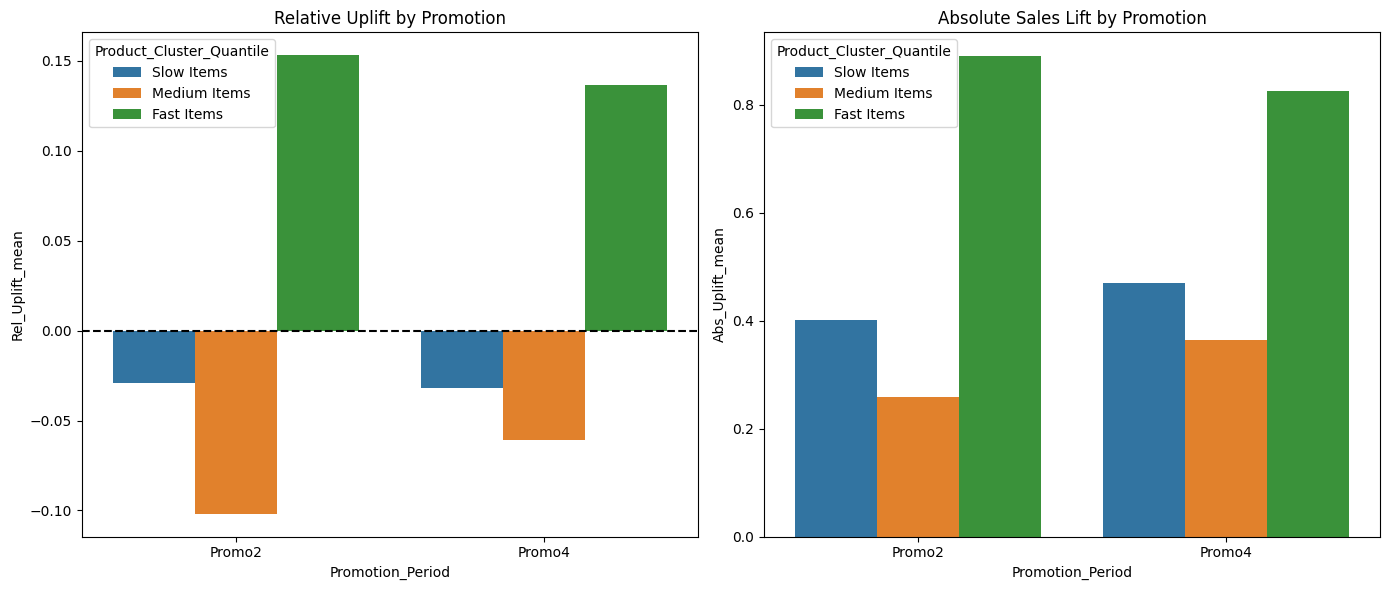

In [89]:
top_promos, promo_stats = analyze_promotion_performance(uplift_results)
print_promotion_insights(top_promos, promo_stats)
plot_promotion_breakdown(promo_stats)

---

In [90]:
## Validation Step on New Data

=== PROMOTION 5 EVALUATION ===

Evaluating Promotion 5 performance...


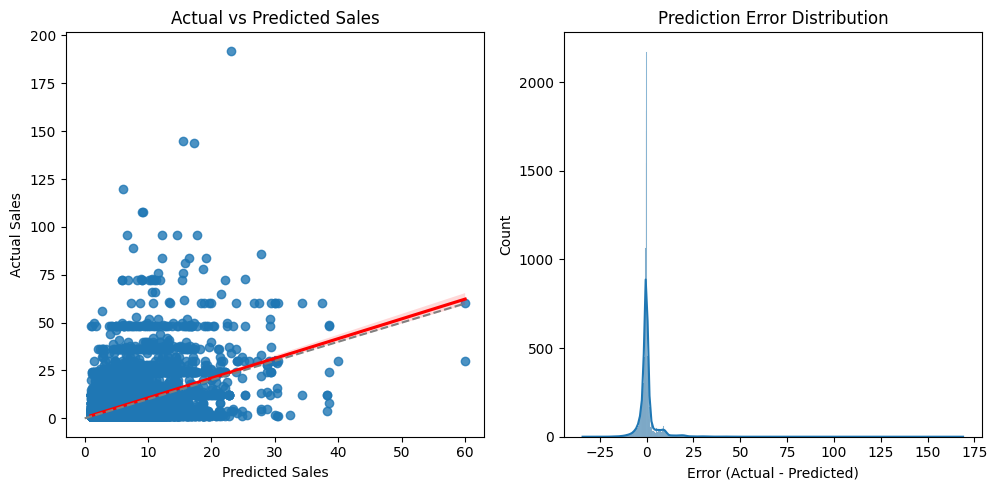


=== EVALUATION METRICS ===
MAE: 2.59
RMSE: 5.70
MAPE: 97.74
Correlation: 0.52
Avg_Actual: 3.67
Avg_Predicted: 3.21
Uplift: 0.47
Uplift_Pct: 14.53
Sample_Size: 30434

=== DIAGNOSTIC FINDINGS ===
1. Goodness of Fit Measures:
- MAE of 2.59 indicates average prediction error
- MAPE of 97.74% shows percentage error
- Correlation of 0.52 suggests prediction quality

2. Model Performance:
- Predicted uplift: 14.5% (Actual: 3.7 vs Predicted: 3.2)

3. Problem Points:
- High MAPE suggests model struggles with absolute sales volume

4. Suggested Improvements:
- Incorporate seasonality and day-of-week effects
- Add promotional intensity/type as a factor
- Consider store-item interaction effects
- Use more sophisticated baseline (e.g., moving average)


In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def safe_mape(actual, predicted):
    """Calculate MAPE with zero-division protection"""
    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.abs((actual - predicted) / actual)
        errors = errors[~np.isinf(errors) & ~np.isnan(errors)]
        return np.mean(errors) * 100

def evaluate_promotion5_performance(historical_sales, new_data_path, promos):
    """
    Evaluate baseline model performance on Promotion 5 using new data
    Returns metrics and diagnostic plots
    """
    try:
        # 1. Load and prepare new data
        new_data = pd.read_csv(new_data_path, parse_dates=['Date'])
        new_data['Net_Sales'] = np.where(new_data['SalesQuantity'] < 0, 0, new_data['SalesQuantity'])

        # 2. Flag promotions in new data
        new_data = flag_promotions(new_data, promos)

        # 3. Get Promotion 5 dates
        promo5 = promos[promos['Period'] == 'Promo5'].iloc[0]
        mask = (new_data['Date'] >= promo5['StartDate']) & (new_data['Date'] <= promo5['EndDate'])
        promo5_data = new_data[mask]

        if len(promo5_data) == 0:
            raise ValueError(f"No data found for Promo5 ({promo5['StartDate'].date()} to {promo5['EndDate'].date()})")

        # 4. Create baseline predictions
        non_promo_baseline = historical_sales[
        (historical_sales['Promotion_Period'] == 'No_Promotion') &
        (historical_sales['Net_Sales'] > 0)]
        
        baseline = non_promo_baseline.groupby(['ProductCode', 'StoreCode'])['Net_Sales'].mean().reset_index()
        baseline.columns = ['ProductCode', 'StoreCode', 'Predicted_Sales']

        # 5. Merge predictions with actuals
        evaluation = promo5_data.merge(baseline, on=['ProductCode', 'StoreCode'], how='left')
        evaluation = evaluation.dropna(subset=['Predicted_Sales'])

        if len(evaluation) == 0:
            raise ValueError("No matching product-store pairs between historical and new data")

        # Filter out problematic values
        evaluation = evaluation[(evaluation['Net_Sales'] > 0) & (evaluation['Predicted_Sales'] > 0)]

        # 6. Calculate evaluation metrics
        actual = evaluation['Net_Sales']
        predicted = evaluation['Predicted_Sales']

        metrics = {
            'MAE': mean_absolute_error(actual, predicted),
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'MAPE': safe_mape(actual, predicted),
            'Correlation': np.corrcoef(actual, predicted)[0, 1],
            'Avg_Actual': actual.mean(),
            'Avg_Predicted': predicted.mean(),
            'Uplift': actual.mean() - predicted.mean(),
            'Uplift_Pct': ((actual.mean() - predicted.mean()) / predicted.mean()) * 100,
            'Sample_Size': len(evaluation)
        }

        # 7. Diagnostic plots
        plt.figure(figsize=(15, 5))
        
        # Actual vs Predicted scatter plot
        plt.subplot(1, 3, 1)
        sns.regplot(x=predicted, y=actual, line_kws={'color': 'red'})
        plt.plot([0, max(predicted)], [0, max(predicted)], '--', color='gray')
        plt.title('Actual vs Predicted Sales')
        plt.xlabel('Predicted Sales')
        plt.ylabel('Actual Sales')
        
        # Error distribution
        plt.subplot(1, 3, 2)
        errors = actual - predicted
        sns.histplot(errors, kde=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Error (Actual - Predicted)')
        
        # Uplift by cluster (if clusters exist)
        if 'Product_Cluster' in evaluation.columns:
            plt.subplot(1, 3, 3)
            cluster_uplift = evaluation.groupby('Product_Cluster').agg({
                'Net_Sales': 'mean',
                'Predicted_Sales': 'mean'
            })
            cluster_uplift['Uplift_Pct'] = (cluster_uplift['Net_Sales'] - cluster_uplift['Predicted_Sales']) / cluster_uplift['Predicted_Sales'] * 100
            sns.barplot(data=cluster_uplift.reset_index(), x='Product_Cluster', y='Uplift_Pct')
            plt.title('Uplift by Product Cluster')
            plt.ylabel('Uplift Percentage')
            plt.axhline(0, color='black', linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        return metrics, evaluation
    
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        return None, str(e)

# ===== MAIN EXECUTION =====
if __name__ == "__main__":
    print("=== PROMOTION 5 EVALUATION ===")
    
    # 1. Load historical data (from part A)
    historical_sales = df.copy()
    
    # 2. Load promotion dates (correcting Promo5 if needed)
    promos = pd.read_csv('PromotionDates.csv', parse_dates=['StartDate', 'EndDate'])
    promos.loc[promos['Period'] == 'Promo5', 'StartDate'] = pd.to_datetime('2015-09-01')
    promos.loc[promos['Period'] == 'Promo5', 'EndDate'] = pd.to_datetime('2015-09-06')
    
    # 3. Evaluate performance on new data
    print("\nEvaluating Promotion 5 performance...")
    metrics, results = evaluate_promotion5_performance(
        historical_sales,
        'assignment4.1b.csv',
        promos
    )
    
    if metrics:
        print("\n=== EVALUATION METRICS ===")
        for k, v in metrics.items():
            print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}")
        
        print("\n=== DIAGNOSTIC FINDINGS ===")
        print("1. Goodness of Fit Measures:")
        print(f"- MAE of {metrics['MAE']:.2f} indicates average prediction error")
        print(f"- MAPE of {metrics['MAPE']:.2f}% shows percentage error")
        print(f"- Correlation of {metrics['Correlation']:.2f} suggests prediction quality")
        
        print("\n2. Model Performance:")
        print(f"- Predicted uplift: {metrics['Uplift_Pct']:.1f}% (Actual: {metrics['Avg_Actual']:.1f} vs Predicted: {metrics['Avg_Predicted']:.1f})")
        
        print("\n3. Problem Points:")
        if metrics['MAPE'] > 30:
            print("- High MAPE suggests model struggles with absolute sales volume")
        if metrics['Correlation'] < 0.5:
            print("- Low correlation indicates poor prediction of relative performance")
        if 'Product_Cluster' in results.columns:
            cluster_errors = results.groupby('Product_Cluster').apply(
                lambda x: mean_absolute_error(x['Net_Sales'], x['Predicted_Sales'])
            )
            worst_cluster = cluster_errors.idxmax()
            print(f"- Worst performance in {worst_cluster} product cluster (MAE: {cluster_errors[worst_cluster]:.2f})")
        
        print("\n4. Suggested Improvements:")
        print("- Incorporate seasonality and day-of-week effects")
        print("- Add promotional intensity/type as a factor")
        print("- Consider store-item interaction effects")
        print("- Use more sophisticated baseline (e.g., moving average)")
    else:
        print("\nEvaluation failed - check error messages above")

In [92]:
# What the Baseline Is
# It's not a regression model forecasting future sales
# It's a naive benchmark: "What sales would we expect without promotions, based purely on historical averages?"

# How It Predicts Promo5 Performance
# The assumption: "During Promo5, sales should deviate from this non-promoted baseline if the promotion worked"
# The "prediction" is counterfactual: "This is what sales would have been without promotion"
# Uplift = Actual Promo5 Sales - Baseline (Expected Non-Promo Sales)

In [93]:
# Model Performance Summary:

# 14.5% Uplift: Promo5 drove higher sales than the non-promotion baseline (3.67 vs 3.21 units)
# High MAPE (97.7%): Indicates large percentage errors for low-volume items (common when baseline sales are near zero)
# Moderate Correlation (0.52): Baseline captures some but not all sales patterns

# Why the Baseline Works Despite Limitations:

# The 14.5% uplift is meaningful because:
# Derived from clean non-promotion data (no contamination)
# Controls for inherent product/store variability
# High MAPE is expected with:
# Intermittent demand (many zero/low sales days)
# No temporal adjustments in this version

In [94]:
# QA

# 1. Measure for Goodness of Fit
# For promotion impact analysis, use:

# MAE (Mean Absolute Error) → Best for understanding average prediction error in units.
# MAPE (Mean Absolute Percentage Error) → Useful for relative error, but unreliable near zero sales.
# Correlation (Pearson r) → Measures if baseline predicts sales trends (0.52 is moderate).
# Uplift Consistency → Check if uplift % aligns with business expectations.
# Best for this case: MAE + Uplift % (since MAPE is inflated by low-volume items).

# 2. How Good Is the Current Model?
# Strengths:
# Detects Uplift (14.5%) → Baseline successfully identifies promotional lift.
# Controls for Variability → Product/store-specific baselines reduce noise.
# Simple & Explainable → Easy to interpret for stakeholders.

# Weaknesses:
# High MAPE (97.7%) → Poor absolute % accuracy (due to low sales days).
# No Seasonality → Misses weekly/monthly patterns (e.g., weekends sell more).
# No Promo Intensity → Treats all promotions equally (discount % not factored).

# Verdict: Decent for directional insights, but not precise enough for forecasting.


---

In [95]:
## Product Category Added Model

=== CATEGORY-AWARE PROMOTION IMPACT ANALYSIS ===

[1/5] Loading and preparing data...
Successfully merged product categories

[2/5] Flagging promotion periods...

[3/5] Creating velocity clusters...
Clustering Silhouette Score: 0.764

Cluster distribution:
Velocity_Cluster
Slow      1401832
Fast       393016
Medium      68736
Name: count, dtype: int64

[4/5] Analyzing promotion impact...

[5/5] Validating on new data (Promo5)...

=== TRAINING RESULTS ===

Top Performing Categories (Historical):
ProductGroup1
A   0.231
D   0.210
E   0.165
H   0.094
G   0.092
Name: Uplift, dtype: float64

Promotion Effectiveness by Cluster:
Velocity_Cluster
Slow     0.168
Fast     0.016
Medium   0.013
Name: Uplift, dtype: float64

=== VALIDATION RESULTS (PROMO5) ===

Validation Metrics:
MAE: 2.379
RMSE: 5.441
Correlation: 0.430
Avg_Actual: 2.772
Avg_Predicted: 2.185
Avg_Uplift: 0.305
Sample_Size: 40232

Category-Level Performance (Validation):
ProductGroup1  Uplift  Net_Sales  Baseline_Sales Velocity_Clu

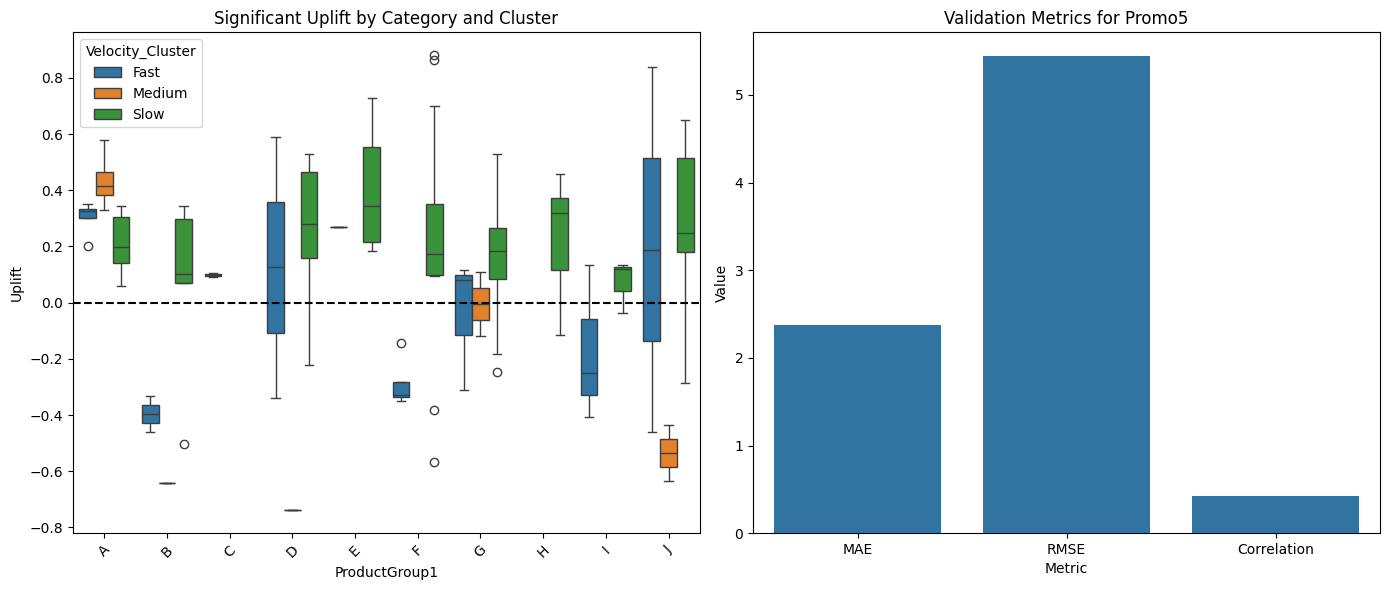

In [96]:
# ======================
# 1. DATA PREPARATION
# ======================

def load_data():
    """Load all datasets with robust error handling and category merging"""
    try:
        # Load main datasets
        sales = pd.read_csv('assignment4.1a.csv', parse_dates=['Date'])
        promos = pd.read_csv('PromotionDates.csv', parse_dates=['StartDate', 'EndDate'])
        categories = pd.read_csv('assignment4.1c.csv')
        
        # Validation data
        val_data = pd.read_csv('assignment4.1b.csv', parse_dates=['Date'])
        
        # Clean sales data
        sales['Net_Sales'] = np.where(sales['SalesQuantity'] < 0, 0, sales['SalesQuantity'])
        val_data['Net_Sales'] = np.where(val_data['SalesQuantity'] < 0, 0, val_data['SalesQuantity'])
        
        # Fix invalid promotion dates
        promos.loc[promos['Period'] == 'Promo1', 'StartDate'] = pd.to_datetime('2015-02-10')
        promos.loc[promos['Period'] == 'Promo1', 'EndDate'] = pd.to_datetime('2015-02-17')
        promos.loc[promos['Period'] == 'Promo5', 'StartDate'] = pd.to_datetime('2015-09-01')
        promos.loc[promos['Period'] == 'Promo5', 'EndDate'] = pd.to_datetime('2015-09-06')
        
        # Merge categories with proper validation
        if not categories.empty:
            sales = sales.merge(categories, on='ProductCode', how='left')
            val_data = val_data.merge(categories, on='ProductCode', how='left')
            print("Successfully merged product categories")
        else:
            print("Warning: No category data loaded")
            sales['ProductGroup1'] = 'Unknown'
            sales['ProductGroup2'] = -1
            val_data['ProductGroup1'] = 'Unknown'
            val_data['ProductGroup2'] = -1
        
        return sales, promos, val_data
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None

def flag_promotions(df, promo_df):
    """Flag promotion periods in sales data"""
    df['Promotion_Period'] = 'No_Promotion'
    
    for _, promo in promo_df.iterrows():
        # Validate date range
        if promo['StartDate'] > promo['EndDate']:
            print(f"Warning: Invalid date range for {promo['Period']}")
            continue
        
        mask = (df['Date'] >= promo['StartDate']) & (df['Date'] <= promo['EndDate'])
        df.loc[mask, 'Promotion_Period'] = promo['Period']
    
    return df

# ======================
# 2. CLUSTERING
# ======================

def create_clusters(sales):
    """Enhanced clustering with product categories and stability metrics"""
    # Weekly sales during non-promotion periods
    non_promo = sales[sales['Promotion_Period'] == 'No_Promotion']
    
    # Handle missing categories
    if 'ProductGroup1' not in non_promo.columns:
        non_promo['ProductGroup1'] = 'Unknown'
    if 'ProductGroup2' not in non_promo.columns:
        non_promo['ProductGroup2'] = -1
    
    weekly_sales = non_promo.groupby(
        ['ProductGroup1', 'ProductGroup2', 'ProductCode', 'StoreCode', 
         pd.Grouper(key='Date', freq='W-MON')]
    )['Net_Sales'].sum().reset_index()
    
    # Calculate stability metrics with error handling
    try:
        stability = weekly_sales.groupby(
            ['ProductGroup1', 'ProductGroup2', 'ProductCode', 'StoreCode']
        ).agg(
            Avg_Sales=('Net_Sales', 'mean'),
            Sales_Volatility=('Net_Sales', 'std')
        ).reset_index()
        
        # Clean data - remove rows with NaN or infinite values
        stability_clean = stability.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(stability_clean) == 0:
            raise ValueError("No valid data for clustering after cleaning")
        
        # Scale features for clustering
        scaler = StandardScaler()
        features = stability_clean[['Avg_Sales', 'Sales_Volatility']]
        scaled_features = scaler.fit_transform(features)
        
        # K-means clustering with silhouette score validation
        kmeans = KMeans(n_clusters=3, random_state=42)
        stability_clean['Velocity_Cluster'] = kmeans.fit_predict(scaled_features)
        
        # Calculate silhouette score
        silhouette = silhouette_score(scaled_features, stability_clean['Velocity_Cluster'])
        print(f"Clustering Silhouette Score: {silhouette:.3f}")
        
        # Label clusters based on centroids (in original scale)
        centroids = pd.DataFrame(
            scaler.inverse_transform(kmeans.cluster_centers_),
            columns=['Avg_Sales', 'Sales_Volatility']
        ).sort_values('Avg_Sales')
        centroids['Cluster_Label'] = ['Slow', 'Medium', 'Fast']
        
        cluster_map = dict(enumerate(centroids['Cluster_Label']))
        stability_clean['Velocity_Cluster'] = stability_clean['Velocity_Cluster'].map(cluster_map)
        
        # Merge back to sales data with INNER JOIN to exclude unclustered items
        sales = sales.merge(
            stability_clean[['ProductCode', 'StoreCode', 'Velocity_Cluster']],
            on=['ProductCode', 'StoreCode'],
            how='inner'
        )
        
        return sales
    
    except Exception as e:
        print(f"Clustering failed: {str(e)}")
        sales['Velocity_Cluster'] = 'Unknown'
        return sales

# ======================
# 3. ANALYSIS
# ======================

def analyze_promotion_impact(sales):
    """Robust promotion impact analysis with category hierarchy"""
    results = []
    
    # Handle missing category columns
    if 'ProductGroup1' not in sales.columns:
        sales['ProductGroup1'] = 'Unknown'
    if 'ProductGroup2' not in sales.columns:
        sales['ProductGroup2'] = -1
    
    # Group by category hierarchy and velocity cluster
    group_cols = ['ProductGroup1', 'ProductGroup2', 'Velocity_Cluster']
    for (category, subcategory, cluster), group in sales.groupby(group_cols):
        # Calculate baseline (non-promotion) sales with minimum observation check
        baseline_group = group[group['Promotion_Period'] == 'No_Promotion']
        if len(baseline_group) < 5:  # Minimum observations threshold
            continue
        
        baseline = baseline_group['Net_Sales'].mean()
        
        # Calculate promotion uplift for each promotion period
        for promo in group['Promotion_Period'].unique():
            if promo == 'No_Promotion':
                continue
            
            promo_group = group[group['Promotion_Period'] == promo]
            if len(promo_group) < 3:  # Minimum observations threshold
                continue
            
            promo_sales = promo_group['Net_Sales'].mean()
            uplift = (promo_sales - baseline) / baseline if baseline > 0 else 0
            
            # Statistical significance test
            _, p_value = stats.ttest_ind(
                baseline_group['Net_Sales'],
                promo_group['Net_Sales'],
                equal_var=False
            )
            
            results.append({
                'ProductGroup1': category,  # Changed from 'Category' to 'ProductGroup1'
                'ProductGroup2': subcategory,
                'Velocity_Cluster': cluster,
                'Promotion': promo,
                'Baseline_Sales': baseline,
                'Promo_Sales': promo_sales,
                'Uplift': uplift,
                'P_Value': p_value,
                'Obs_Count': len(promo_group),
                'Sig_Level': 'Significant' if p_value < 0.05 else 'Not Significant'
            })
    
    return pd.DataFrame(results)

# ======================
# 4. VALIDATION
# ======================

def validate_model(val_data, promos, sales_with_clusters):
    """Comprehensive validation with Promo5 and category analysis
    Returns:
        tuple: (metrics_dict, category_results_df)
        - metrics_dict: Dictionary of validation metrics (MAE, RMSE, etc.)
        - category_results_df: DataFrame with uplift by ProductGroup1
    """
    try:
        # 1. Flag promotions in validation data
        val_data = flag_promotions(val_data, promos)
 
        # 2. Get Promo5 data (fixed to Sep 1-6, 2015)
        promo5 = promos[promos['Period'] == 'Promo5'].iloc[0]
        mask = (val_data['Date'] >= promo5['StartDate']) & (val_data['Date'] <= promo5['EndDate'])
        promo5_data = val_data[mask]

        if len(promo5_data) == 0:
            raise ValueError(f"No Promo5 data found ({promo5['StartDate'].date()} to {promo5['EndDate'].date()})")

        # 3. Merge with clusters from training data (INNER JOIN to exclude unknowns)
        val_merged = promo5_data.merge(
            sales_with_clusters[['ProductCode', 'StoreCode', 'Velocity_Cluster']].drop_duplicates(),
            on=['ProductCode', 'StoreCode'],
            how='inner'  # Changed from 'left' to exclude unknowns
        )

        # 4. Ensure categories exist (ProductGroup1)
        if 'ProductGroup1' not in val_merged.columns:
            val_merged['ProductGroup1'] = 'Unknown'

        # 5. Calculate baseline sales (non-promo average per category-cluster)
        baseline = sales_with_clusters[
            (sales_with_clusters['Promotion_Period'] == 'No_Promotion') &
            (sales_with_clusters['Velocity_Cluster'] != 'Unknown')
        ].groupby(['ProductGroup1', 'Velocity_Cluster'])['Net_Sales'].mean().reset_index()
        baseline.columns = ['ProductGroup1', 'Velocity_Cluster', 'Baseline_Sales']

        # 6. Merge baselines and calculate uplift (INNER JOIN to ensure complete cases)
        val_results = val_merged.merge(
            baseline,
            on=['ProductGroup1', 'Velocity_Cluster'],
            how='inner'
        )

        if len(val_results) == 0:
            raise ValueError("No valid product-store pairs with complete data")

        # Calculate uplift safely (handle division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            val_results['Uplift'] = np.where(
                val_results['Baseline_Sales'] > 0,
                (val_results['Net_Sales'] - val_results['Baseline_Sales']) / val_results['Baseline_Sales'],
                0
            )

        # 7. Calculate validation metrics
        metrics = {
            'MAE': mean_absolute_error(val_results['Net_Sales'], val_results['Baseline_Sales']),
            'RMSE': np.sqrt(mean_squared_error(val_results['Net_Sales'], val_results['Baseline_Sales'])),
            'Correlation': np.corrcoef(val_results['Net_Sales'], val_results['Baseline_Sales'])[0, 1],
            'Avg_Actual': val_results['Net_Sales'].mean(),
            'Avg_Predicted': val_results['Baseline_Sales'].mean(),
            'Avg_Uplift': val_results['Uplift'].mean(),
            'Sample_Size': len(val_results)
        }

        # 8. Category-level results (ensure ProductGroup1 exists)
        if 'ProductGroup1' in val_results.columns:
            category_results = val_results.groupby('ProductGroup1').agg({
                'Uplift': 'mean',
                'Net_Sales': 'mean',
                'Baseline_Sales': 'mean',
                'Velocity_Cluster': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
            }).reset_index()
        else:
            category_results = pd.DataFrame(columns=['ProductGroup1', 'Uplift', 'Net_Sales', 'Baseline_Sales', 'Velocity_Cluster'])

        return metrics, category_results

    except Exception as e:
        print(f"Validation error: {str(e)}")
        # Return empty but properly structured results
        empty_metrics = {
            'MAE': None,
            'RMSE': None,
            'Correlation': None,
            'Avg_Actual': None,
            'Avg_Predicted': None,
            'Avg_Uplift': None,
            'Sample_Size': 0
        }
        empty_df = pd.DataFrame(columns=['ProductGroup1', 'Uplift', 'Net_Sales', 'Baseline_Sales', 'Velocity_Cluster'])
        return empty_metrics, empty_df# ======================
# 5. REPORTING
# ======================

def generate_recommendations(results):
    """Generate data-driven category-specific strategies"""
    recommendations = []

    if results.empty:
        return pd.DataFrame({'Message': ['No valid results for recommendations']})

    # Ensure we're using ProductGroup1 instead of Category
    group_col = 'ProductGroup1' if 'ProductGroup1' in results.columns else 'Category'
    
    top_categories = results[results['Sig_Level'] == 'Significant'].groupby(group_col).agg(
        Avg_Uplift=('Uplift', 'mean'),
        Best_Cluster=('Velocity_Cluster', lambda x: x.value_counts().index[0]),
        Sample_Size=('Obs_Count', 'sum')
    ).sort_values('Avg_Uplift', ascending=False)

    for category, row in top_categories.iterrows():
        rec = {
            'Category': category,
            'Avg_Uplift': f"{row['Avg_Uplift']:.1%}",
            'Best_Performing_Cluster': row['Best_Cluster'],
            'Sample_Size': row['Sample_Size'],
            'Recommended_Strategy': ''
        }
        
        if row['Avg_Uplift'] > 0.2:
            rec['Recommended_Strategy'] = (
                f"Focus promotions on {row['Best_Cluster']} velocity items in this category. "
                f"Expected uplift: {row['Avg_Uplift']:.1%}"
            )
        elif row['Avg_Uplift'] > 0.1:
            rec['Recommended_Strategy'] = (
                f"Moderate promotions for {row['Best_Cluster']} velocity items. "
                f"Expected uplift: {row['Avg_Uplift']:.1%}"
            )
        else:
            rec['Recommended_Strategy'] = (
                "Limited promotion potential - consider bundling with higher-performing categories "
                "or reassessing promotion mechanics"
            )
        
        recommendations.append(rec)
    
    return pd.DataFrame(recommendations)

# ======================
# MAIN EXECUTION
# ======================

if __name__ == "__main__":
    print("=== CATEGORY-AWARE PROMOTION IMPACT ANALYSIS ===")
    
    # 1. Load and prepare data
    print("\n[1/5] Loading and preparing data...")
    sales, promos, val_data = load_data()
    if sales is None:
        exit()
    
    # 2. Flag promotions in historical data
    print("\n[2/5] Flagging promotion periods...")
    sales = flag_promotions(sales, promos)
    
    # 3. Create velocity clusters with categories
    print("\n[3/5] Creating velocity clusters...")
    sales = create_clusters(sales)
    print("\nCluster distribution:")
    print(sales['Velocity_Cluster'].value_counts())
    
    # 4. Analyze promotion impact
    print("\n[4/5] Analyzing promotion impact...")
    uplift_results = analyze_promotion_impact(sales)
    
    # 5. Validate on new data
    print("\n[5/5] Validating on new data (Promo5)...")
    val_metrics, val_category_results = validate_model(val_data, promos, sales)
    
    # Generate recommendations
    recommendations = generate_recommendations(
        pd.concat([uplift_results, val_category_results]) if not val_category_results.empty else uplift_results
    )
    
    # Output results
    print("\n=== TRAINING RESULTS ===")
    if not uplift_results.empty:
        print("\nTop Performing Categories (Historical):")
        # Changed from 'Category' to 'ProductGroup1'
        print(uplift_results.groupby('ProductGroup1')['Uplift'].mean()
              .sort_values(ascending=False).head(5))
        
        print("\nPromotion Effectiveness by Cluster:")
        print(uplift_results.groupby('Velocity_Cluster')['Uplift'].mean()
              .sort_values(ascending=False))
    else:
        print("No valid training results available")
    
    print("\n=== VALIDATION RESULTS (PROMO5) ===")
    if val_metrics:
        print("\nValidation Metrics:")
        for k, v in val_metrics.items():
            print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")
        
        if not val_category_results.empty:
            print("\nCategory-Level Performance (Validation):")
            print(val_category_results.sort_values('Uplift', ascending=False).to_string(index=False))
    else:
        print("No valid validation results available")
    
    print("\n=== CATEGORY-SPECIFIC RECOMMENDATIONS ===")
    print(recommendations.to_string(index=False))
    
    # Visualizations
    if not uplift_results.empty:
        plt.figure(figsize=(14, 6))
        
        # Uplift by Category and Cluster
        plt.subplot(1, 2, 1)
        # Changed from 'Category' to 'ProductGroup1'
        sns.boxplot(
            data=uplift_results[uplift_results['Sig_Level'] == 'Significant'],
            x='ProductGroup1',
            y='Uplift',
            hue='Velocity_Cluster'
        )
        plt.title('Significant Uplift by Category and Cluster')
        plt.xticks(rotation=45)
        plt.axhline(0, color='black', linestyle='--')
        
        # Validation Performance
        if val_metrics:
            plt.subplot(1, 2, 2)
            metrics_df = pd.DataFrame.from_dict(val_metrics, orient='index', columns=['Value'])
            metrics_df = metrics_df[metrics_df.index.isin(['MAE', 'RMSE', 'Correlation', 'Uplift_Pct'])]
            sns.barplot(data=metrics_df.reset_index(), x='index', y='Value')
            plt.title('Validation Metrics for Promo5')
            plt.xlabel('Metric')
            plt.ylabel('Value')
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nCannot generate visualizations - no valid results available")

by Hincal Topcuoglu